# LIM analysis of the Annular indices in the CMIP6 for the extended winter

## Import modules

In [1]:
import math
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import os

import calendar
import datetime as dt

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# %matplotlib inline
mpl.rc('image', cmap='bwr')

from get_AM_mod import JRA55, CMIP6, ERA5, NAM, SAM, get_y
from tools_AM_mod import cov_lag, find_event
from LIM_AM_mod import LIM, rand_model
from stats_mod import stats_tests_normal, stats_tests_rand_model, bootstrap, percentile_ci, bootstrap_model, StackArray

from numpy import linalg as la

# with open("model_list.txt", "r") as f:
#     model_list = f.readlines()
#     model_list = [d.replace("\n", "") for d in model_list]
with open("model_list2.txt", "r") as f:
    model_list2 = f.readlines()
    model_list = []
    model_top = []
    for d in model_list2:
        list, top = d.split(",", 1)
        model_list.append(list)
        model_top.append(float(top))
# model_list.remove("CESM2")
# D = D_list[model_list.index('HadGEM3-GC31-LL')]
# print(D.name)

plev = [850.,  700.,  500.,  250.,  100.,   50.,   10.]
len_slice = 150
offset = 40

## Load JRA55 and CMIP6 data
`Notations`
* y: original data
* y2: original data + padding of length `offset` before and after for composite analysis
* y3: data generated by random model

In [2]:
data = ERA5(name_dir='ERA5', year_start=1950, year_end=2014, plev=plev, source_dir='cmip6')
D0, p0, D0.y, t, D0.y2 = get_y(data, 'NAM', len_slice=len_slice, offset=offset)

D_list = []
for idx, model in enumerate(model_list):
    data = CMIP6(name_dir=model, year_start=1950, year_end=2014, plev=plev, source_dir='cmip6')
    D, p, D.y, t, D.y2 = get_y(data, 'NAM', len_slice=len_slice, offset=offset, save_index=True)
    D.hightop = model_top[idx] < 1.0
    
    D_list.append(D)

print(f"total number of models: {len(D_list)}")

Calculating from the original data .......
ERA5 (65, 365, 7) 	calendar: 365_day
t.shape = (150,), y.shape = (64, 150, 7), y2.shape = (64, 230, 7)
Reading from saved data ......
ACCESS-CM2 (65, 365, 7) 	calendar: 365_day
t.shape = (150,), y.shape = (64, 150, 7), y2.shape = (64, 230, 7)
Reading from saved data ......
BCC-ESM1 (65, 365, 7) 	calendar: 365_day
t.shape = (150,), y.shape = (64, 150, 7), y2.shape = (64, 230, 7)
Reading from saved data ......
CanESM5 (65, 365, 7) 	calendar: 365_day
t.shape = (150,), y.shape = (64, 150, 7), y2.shape = (64, 230, 7)
Reading from saved data ......
CESM2 (65, 365, 7) 	calendar: 365_day
t.shape = (150,), y.shape = (64, 150, 7), y2.shape = (64, 230, 7)
Reading from saved data ......
CESM2-WACCM (65, 365, 7) 	calendar: 365_day
t.shape = (150,), y.shape = (64, 150, 7), y2.shape = (64, 230, 7)
Reading from saved data ......
CNRM-CM6 (65, 365, 7) 	calendar: 365_day
t.shape = (150,), y.shape = (64, 150, 7), y2.shape = (64, 230, 7)
Reading from saved data .

## Hyperparameters

In [3]:
hyp_param = dict(lim = dict(lag_time = 5,
                            r_optimal = 4,
                            eig_method = 'pinv',
                            ord   = 2,
                            )
                )
print(f'hyperpamameters:\n{hyp_param}')

hyperpamameters:
{'lim': {'lag_time': 5, 'r_optimal': 4, 'eig_method': 'pinv', 'ord': 2}}


## Model

In [4]:
def compute_tau(y, p, p_level, lag_time, verbose=False):
    lags = np.arange(lag_time+1)
    k = np.isin(p, p_level)
    Ct = np.array([cov_lag(y[:, :, k], lag) for lag in lags])

    from scipy.optimize import curve_fit
    func = lambda x, b: np.exp(-b * x)
    popt, pcov = curve_fit(func, lags, Ct/Ct[0])

    if verbose:
        plt.plot(lags, Ct/Ct[0])
        plt.plot(lags, func(lags, *popt))

    return 1.0/popt[0]

def run_model(D0, t, lag_time, verbose=False):
    print(f'==================== {D0.data.name} ====================')
    D0.tau10 = compute_tau(D0.y, D0.data.level, p_level=10, lag_time=lag_time, verbose=False)

    D0.model = LIM(D0.y, hyp_param, verbose=True)
    
    D0.y3 = rand_model(D0.model.B_r, D0.model.vr_Q, D0.model.w_Q, len_day=len_slice*1000, dt=0.2, verbose=False, get_x_from_r=D0.model.get_x_from_r)

    # decomposition by modes
    y2_mode = D0.model.mode(D0.y2)
    y3_mode = D0.model.mode(D0.y3)
    # Define the strat-trop coupling mode
    D0.y2_strat = y2_mode[:,:,:,:2].sum(axis=3)
    D0.y3_strat = y3_mode[:,:,:2].sum(axis=2)
    
    if D0.model.b[0].real == D0.model.b[1].real:
        D0.complex_strat = True
    else:
        D0.complex_strat = False

lag_time_tau = 20
run_model(D0, t, lag_time_tau, verbose=True)

for D in D_list:
    run_model(D, t, lag_time_tau)

==================== ERA5 ====================
POP e-folding timescales =30.1981, 30.1981, 7.8904, 4.2632
r_opt=4: % of var=99.806541, norm=2.006132, err=0.484062, R2=0.515938, s=1.070690
==================== ACCESS-CM2 ====================
POP e-folding timescales =27.4552, 16.1688, 11.0138, 3.9913
r_opt=4: % of var=99.840324, norm=2.093479, err=0.442364, R2=0.557636, s=1.082796
==================== BCC-ESM1 ====================
POP e-folding timescales =24.7645, 24.7645, 12.0682, 5.3484
r_opt=4: % of var=99.861000, norm=2.065394, err=0.454151, R2=0.545849, s=0.986158
==================== CanESM5 ====================
POP e-folding timescales =36.2182, 17.1622, 8.0309, 5.2691
r_opt=4: % of var=99.855957, norm=1.928990, err=0.433039, R2=0.566961, s=1.031428
==================== CESM2 ====================
POP e-folding timescales =27.5732, 15.2017, 9.1442, 4.7193
r_opt=4: % of var=99.879478, norm=1.809745, err=0.455136, R2=0.544864, s=0.979066
==================== CESM2-WACCM ===========

## Eigenvalues and eigenvectors

In [5]:
# bootstrap of eigenvalues and eigenvectors
Stack_LIM = StackArray()

def stat_func(y, axis):
    model = LIM(y, hyp_param, verbose=False)
    Stack_LIM.add_array('b_r', model.b.real)
    Stack_LIM.add_array('b_i', model.b.imag)
    sn = np.sign(model.vr[p0==500, 0].real)*la.norm(model.vr[:, 0])/np.sqrt(len(model.vr))
    Stack_LIM.add_array('vr_r', model.vr.real/sn)
    Stack_LIM.add_array('vr_i', model.vr.imag/sn)
    tau10 = compute_tau(y, p0, p_level=10, lag_time=lag_time_tau, verbose=False)
    Stack_LIM.add_array('tau10', tau10)
    return Stack_LIM.stack()

ci_stacked, dis_stacked, se_stacked = bootstrap(D0.y, statistic=stat_func, n_resamples=1000, confidence_level=0.95, random_state=42, method='percentile')

ci = (Stack_LIM.unstack(ci_stacked[0], 'low'), Stack_LIM.unstack(ci_stacked[1], 'high'))
dis = Stack_LIM.unstack(dis_stacked, axis=1)

In [6]:
print(-1/D0.model.b.real)
print(2*np.pi/D0.model.b.imag)

[30.198149  30.198149   7.8904076  4.2631764]
[ 224.53981 -224.53981        inf        inf]


/tmp/ipykernel_37116/2059301833.py:2: RuntimeWarning: divide by zero encountered in divide
  print(2*np.pi/D0.model.b.imag)


MME: 24.78561966507523,	 ERA5: (25.443945466542658, 34.98577659731728)


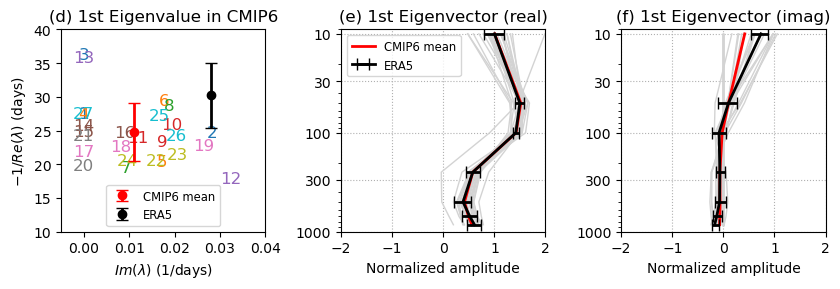

In [7]:
fig = plt.figure(figsize=(8.5,3))
sym = ['o', '^', 'd', 's', 'p', 'h']
colors = plt.cm.tab10(np.linspace(0, 1, len(D_list)))

x0 = np.empty(len(D_list))
y0 = np.empty(len(D_list))
for i, D in enumerate(D_list):
    model = D.model
    x0[i], y0[i] = model.b[0].imag, -1/model.b[0].real

fig.add_subplot(1,3,1)
model = D0.model
markersize = 6
plt.gca().errorbar(x0.mean(), y0.mean(), yerr=y0.std(), fmt=sym[0]+'r', linewidth=2, capsize=4, zorder=29, label='CMIP6 mean')
for mm in range(1):
    yerr = [[-1/model.b[mm].real + 1/ci[0].b_r[mm]], [-1/ci[1].b_r[mm] + 1/model.b[mm].real]]
    # xerr = [[model.b[mm].imag - ci[0].b_i[mm]], [ci[1].b_i[mm] - model.b[mm].imag]]
    plt.errorbar(model.b[mm].imag, -1/model.b[mm].real, yerr, fmt=sym[mm]+'k', linewidth=2, capsize=4, zorder=30, label=r'ERA5')

for idx, D in enumerate(D_list):
    model = D.model
    # mfc = 'none'
    # line, = plt.plot(model.b[0].imag, -1/model.b[0].real, sym[0], mfc=mfc, ms=markersize, color=colors[idx])
    plt.text(model.b[0].imag, -1/model.b[0].real, str(idx+1), ha='center', va='center', color=colors[idx], fontsize=12)

print(f'MME: {y0.mean()},\t ERA5: ({-1/ci[0].b_r[0]}, {-1/ci[1].b_r[0]})')
plt.xlim((-0.005, 0.04))
plt.xticks([0, 0.01, 0.02, 0.03, 0.04])
plt.ylim((10, 40))
plt.xlabel(r'$Im(\lambda)$ (1/days)')
plt.ylabel(r'$-1/Re(\lambda)$ (days)')
plt.title('(d) 1st Eigenvalue in CMIP6')
plt.legend(fontsize='small', loc='lower center')

def get_eig(D0, p, real_eig=True):
    model = D0.model 
    sn = np.sign(model.vr[np.array(p)==100, 0].real)*la.norm(model.vr[:, 0])/np.sqrt(len(model.vr))
    if real_eig:
        eig = model.vr[:, 0].real/sn
    else:
        eig = model.vr[:, 0].imag/sn
    return eig

fig.add_subplot(1,3,2)
eig0 = get_eig(D0, p0)
xerr = [eig0-ci[0].vr_r[:,0], ci[1].vr_r[:,0]-eig0]
plt.errorbar(eig0, p0, xerr=xerr, fmt='k', linewidth=2, capsize=4, mfc='none', zorder=30, label=D0.data.name)
# plt.fill_betweenx(p0, ci[0].vr_r[:, 0], ci[1].vr_r[:, 0], zorder=30, color='green', alpha=0.3)
eig = np.empty((len(D_list), *eig0.shape))
for i, D in enumerate(D_list):
    eig[i,:] = get_eig(D, p)
    plt.plot(eig[i].T, p, color='lightgray', linewidth=1)
plt.plot(eig.mean(axis=0), p, color='r', linewidth=2, zorder=29, label=f'CMIP6 mean')
# plt.errorbar(eig.mean(axis=0), p, xerr=eig.std(axis=0), fmt='r', linewidth=2, capsize=markersize/2, mfc='none', zorder=28, label=f'CMIP6 mean')

plt.ylim((9, 1000))
plt.gca().invert_yaxis()
plt.xlabel('Normalized amplitude')
# plt.ylabel('Pressure (hPa)')
plt.xlim((-2, 2))
plt.xticks([-2, -1, 0, 1, 2])
plt.yscale('log')
plt.yticks([10, 30, 100, 300, 1000])
plt.grid(linestyle=':')
plt.title('(e) 1st Eigenvector (real)')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.legend(fontsize='small')

fig.add_subplot(1,3,3)
eig0 = get_eig(D0, p0, real_eig=False)
xerr = [eig0-ci[0].vr_i[:,0], ci[1].vr_i[:,0]-eig0]
plt.errorbar(eig0, p0, xerr=xerr, fmt='k', linewidth=2, capsize=4, mfc='none', zorder=30, label=D0.data.name)
# plt.fill_betweenx(p0, ci[0].vr_i[:, 0], ci[1].vr_i[:, 0], zorder=30, color='green', alpha=0.3)
eig = np.empty((len(D_list), *eig0.shape))
for i, D in enumerate(D_list):
    eig[i,:] = get_eig(D, p, real_eig=False)
    plt.plot(eig[i].T, p, color='lightgray', linewidth=1)
plt.plot(eig.mean(axis=0), p, color='r', linewidth=2, zorder=29, label=f'CMIP6 mean')
# plt.errorbar(eig.mean(axis=0), p, xerr=eig.std(axis=0), fmt='r', linewidth=2, capsize=markersize/2, mfc='none', zorder=28, label=f'CMIP6 mean')

plt.ylim((9, 1000))
plt.gca().invert_yaxis()
plt.xlabel('Normalized amplitude')
# plt.ylabel('Pressure (hPa)')
plt.xlim((-2, 2))
plt.xticks([-2, -1, 0, 1, 2])
plt.yscale('log')
plt.yticks([10, 30, 100, 300, 1000])
plt.grid(linestyle=':')
plt.title('(f) 1st Eigenvector (imag)')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
# plt.legend()

plt.tight_layout()
# plt.savefig('Figs/LIM_eigs_cmip6.pdf', transparent=True)

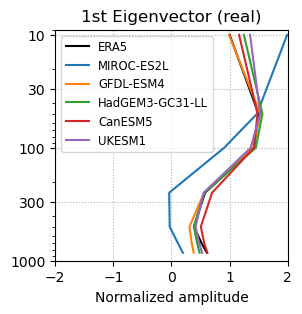

In [8]:
eig0 = get_eig(D0, p0)
eig = np.empty((len(D_list), *eig0.shape))
for i, D in enumerate(D_list):
    eig[i,:] = get_eig(D, p)

fig = plt.figure(figsize=(3,3))
plt.plot(eig0, p0, '-k', label=D0.data.name)
idx = model_list.index('MIROC-ES2L')
plt.plot(eig[idx,:],p, label=D_list[idx].data.name)
idx = model_list.index('GFDL-ESM4')
plt.plot(eig[idx,:],p, label=D_list[idx].data.name)
idx = model_list.index('HadGEM3-GC31-LL')
plt.plot(eig[idx,:],p, label=D_list[idx].data.name)
idx = model_list.index('CanESM5')
plt.plot(eig[idx,:],p, label=D_list[idx].data.name)
idx = model_list.index('UKESM1')
plt.plot(eig[idx,:],p, label=D_list[idx].data.name)

plt.ylim((9, 1000))
plt.gca().invert_yaxis()
plt.xlabel('Normalized amplitude')
# plt.ylabel('Pressure (hPa)')
plt.xlim((-2, 2))
plt.xticks([-2, -1, 0, 1, 2])
plt.yscale('log')
plt.yticks([10, 30, 100, 300, 1000])
plt.grid(linestyle=':')
plt.title('1st Eigenvector (real)')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.legend(fontsize='small')

## Lagged regression

In [9]:
def cal_Ct_p(y, p, p_level):
    k = np.isin(p, p_level)
    Ct_p = np.array([cov_lag(y[:, :, :], lag, -y[:, :, k]) for lag in lags])
    Ct_p_lag = np.array([cov_lag(-y[:, :, k], lag, y[:, :, :]) for lag in lags])
    return Ct_p, Ct_p_lag

lag_time = 40
lags = np.arange(lag_time+1)
lags2= range(-lag_time, lag_time+1)

Ct0_p0, Ct0_p0_lag = cal_Ct_p(D0.y, p0, p_level=10)
Ct0_p2, Ct0_p2_lag = cal_Ct_p(D0.y2_strat[:,offset:offset+len_slice,:], p0, p_level=10)
Ct0_p3, Ct0_p3_lag = cal_Ct_p(D0.y3[None, :], p0, p_level=10)  # using data from the random model

p_level2 = 850
k = np.isin(D0.data.level, p_level2)
Ct0_p0_k=np.vstack((np.flipud(Ct0_p0_lag[1:, k]), Ct0_p0[:, k]))
Ct0_p2_k=np.vstack((np.flipud(Ct0_p2_lag[1:, k]), Ct0_p2[:, k]))
Ct0_p3_k=np.vstack((np.flipud(Ct0_p3_lag[1:, k]), Ct0_p3[:, k]))

Ct_p0 = np.empty((len(D_list), *Ct0_p0.shape))
Ct_p0_lag = np.empty_like(Ct_p0)
Ct_p2 = np.empty((len(D_list), *Ct0_p2.shape))
Ct_p2_lag = np.empty_like(Ct_p2)
Ct_p3 = np.empty((len(D_list), *Ct0_p3.shape))
Ct_p3_lag = np.empty_like(Ct_p3)

Ct_p0_k = np.empty((len(D_list), *Ct0_p0_k.shape))
Ct_p2_k = np.empty((len(D_list), *Ct0_p2_k.shape))
Ct_p3_k = np.empty((len(D_list), *Ct0_p3_k.shape))

for i, D in enumerate(D_list):
    print(f'==================== {D.data.name} ====================')
    Ct_p0[i, :, :], Ct_p0_lag[i, :, :] = cal_Ct_p(D.y, p, p_level=10)
    Ct_p2[i, :, :], Ct_p2_lag[i, :, :] = cal_Ct_p(D.y2_strat[:,offset:offset+len_slice,:], p, p_level=10)
    Ct_p3[i, :, :], Ct_p3_lag[i, :, :] = cal_Ct_p(D.y3[None, :], p, p_level=10)  # using data from the random model

    k = np.isin(D.data.level, p_level2)
    Ct_p0_k[i, :]=np.vstack((np.flipud(Ct_p0_lag[i, 1:, k].reshape(-1, 1)), Ct_p0[i, :, k].reshape(-1, 1)))
    Ct_p2_k[i, :]=np.vstack((np.flipud(Ct_p2_lag[i, 1:, k].reshape(-1, 1)), Ct_p2[i, :, k].reshape(-1, 1)))
    Ct_p3_k[i, :]=np.vstack((np.flipud(Ct_p3_lag[i, 1:, k].reshape(-1, 1)), Ct_p3[i, :, k].reshape(-1, 1)))

==================== ACCESS-CM2 ====================
==================== BCC-ESM1 ====================
==================== CanESM5 ====================
==================== CESM2 ====================
==================== CESM2-WACCM ====================
==================== CNRM-CM6 ====================
==================== CNRM-CM6-HR ====================
==================== CNRM-ESM2 ====================
==================== EC-Earth3 ====================
==================== FGOALS-f3-L ====================
==================== FGOALS-g3 ====================
==================== GFDL-ESM4 ====================
==================== HadGEM3-GC31-LL ====================
==================== HadGEM3-GC31-MM ====================
==================== INM-CM4 ====================
==================== INM-CM5 ====================
==================== IPSL-CM6A-LR ====================
==================== KACE ====================
==================== MIROC6 ====================
==========

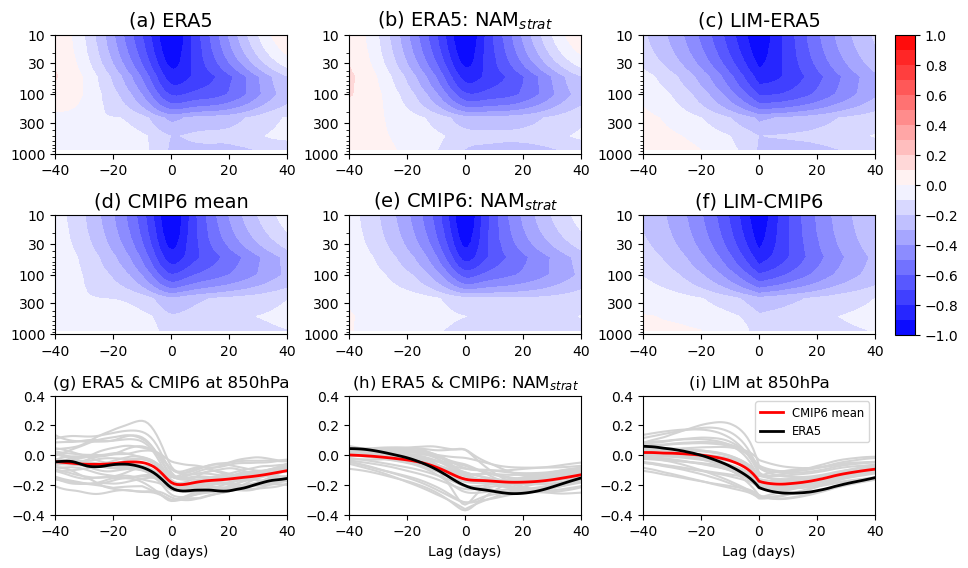

In [10]:
def plot_lag_reg(name, p, Ct_p0, Ct_p0_lag, scale=1.0):
    plt.contourf(lags2, p, np.vstack((np.flipud(Ct_p0_lag[1:,:]), Ct_p0)).T/scale, np.linspace(-cmax, cmax, cnum*2-1), cmap=cm)
    # plt.plot(np.zeros_like(p), p, '--k')
    plt.gca().invert_yaxis()
    plt.yscale('log')
    plt.yticks([10, 30, 100, 300, 1000])
    # plt.ylabel('hPa')
    plt.xticks([-40, -20, 0, 20, 40])
    # plt.xlabel('Lag (days)')
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title(name, fontsize=14)

cm = 'bwr' # 'seismic' # 'RdBu_r'
fig = plt.figure(figsize=(10,6))
mpl.rcParams.update({'font.size': 10})

cmax, cnum = 1, 11
ax1 = fig.add_subplot(3, 3, 1)
plot_lag_reg('(a) ERA5', D0.data.level, Ct0_p0, Ct0_p0_lag, scale=-Ct0_p0[0,0])

ax1 = fig.add_subplot(3, 3, 4)
plot_lag_reg('(d) CMIP6 mean', D.data.level, Ct_p0.mean(axis=0), Ct_p0_lag.mean(axis=0), scale=-Ct_p0.mean(axis=0)[0,-1])

ax1 = fig.add_subplot(3, 3, 2)
plot_lag_reg(f'(b) ERA5'+r': NAM$_{strat}$', D0.data.level, Ct0_p2, Ct0_p2_lag, scale=-Ct0_p2[0,0])

ax1 = fig.add_subplot(3, 3, 5)
plot_lag_reg(f'(e) CMIP6'+r': NAM$_{strat}$', D.data.level, Ct_p2.mean(axis=0), Ct_p2_lag.mean(axis=0), scale=-Ct_p2.mean(axis=0)[0,-1])

ax1 = fig.add_subplot(3, 3, 3)
plot_lag_reg('(c) LIM-ERA5', D0.data.level, Ct0_p3, Ct0_p3_lag, scale=-Ct0_p3[0,0])

ax1 = fig.add_subplot(3, 3, 6)
plot_lag_reg('(f) LIM-CMIP6', D.data.level, Ct_p3.mean(axis=0), Ct_p3_lag.mean(axis=0), scale=-Ct_p3.mean(axis=0)[0,-1])

ax1 = fig.add_subplot(3, 3, 7)
ax1.plot(lags2, -np.squeeze(Ct_p0_k).T/Ct_p0.mean(axis=0)[0,-1], color='lightgray')
ax1.plot(lags2, -Ct_p0_k.mean(axis=0)/Ct_p0.mean(axis=0)[0,-1], color='r', linewidth=2, label=f'CMIP6 mean')
ax1.plot(lags2, -Ct0_p0_k/Ct0_p0[0,0], color='k', linewidth=2, label=D0.data.name)
plt.xticks([-40, -20, 0, 20, 40])
ax1.set_xlim((-40, 40))
ax1.set_ylim((-0.4, 0.4))
plt.xlabel('Lag (days)')
plt.title(f'(g) ERA5 & CMIP6 at {p_level2:.0f}hPa')
# ax1.legend()

ax1 = fig.add_subplot(3, 3, 8)
ax1.plot(lags2, -np.squeeze(Ct_p2_k).T/Ct_p2.mean(axis=0)[0,-1], color='lightgray')
ax1.plot(lags2, -Ct_p2_k.mean(axis=0)/Ct_p2.mean(axis=0)[0,-1], color='r', linewidth=2, label=f'CMIP6 mean')
ax1.plot(lags2, -Ct0_p2_k/Ct0_p2[0,0], color='k', linewidth=2, label=D0.data.name)
plt.xticks([-40, -20, 0, 20, 40])
ax1.set_xlim((-40, 40))
ax1.set_ylim((-0.4, 0.4))
plt.xlabel('Lag (days)')
plt.title(r'(h) ERA5 & CMIP6: NAM$_{strat}$')
# ax1.legend()

ax1 = fig.add_subplot(3, 3, 9)
ax1.plot(lags2, -np.squeeze(Ct_p3_k).T/Ct_p3.mean(axis=0)[0,-1], color='lightgray')
ax1.plot(lags2, -Ct_p3_k.mean(axis=0)/Ct_p3.mean(axis=0)[0,-1], color='r', linewidth=2, label=f'CMIP6 mean')
ax1.plot(lags2, -Ct0_p3_k/Ct0_p3[0,0], color='k', linewidth=2, label=D0.data.name)
plt.xticks([-40, -20, 0, 20, 40])
ax1.set_xlim((-40, 40))
ax1.set_ylim((-0.4, 0.4))
plt.xlabel('Lag (days)')
plt.title(f'(i) LIM at {p_level2:.0f}hPa')
ax1.legend(fontsize='small')

plt.tight_layout()
# horizontal colorbar
# fig.subplots_adjust(bottom=0.22)
# cax = fig.add_axes([0.12, 0.1, 0.80, 0.04])    #[left, bottom, width, height]
# cbar = plt.colorbar(cax=cax, orientation='horizontal')
# cbar.set_ticks(np.linspace(-cmax, cmax, cnum))
# vertical colorbar
fig.subplots_adjust(bottom=0.1, right=0.88, top=0.9)
cax = fig.add_axes([0.90, 0.4, 0.02, 0.5])    #[left, bottom, width, height]
cbar = plt.colorbar(cax=cax, orientation='vertical')
cbar.set_ticks(np.linspace(-cmax, cmax, cnum))

# plt.savefig('Figs/AM_reg_cmip6_LIM.pdf', transparent=True)

## Weak vortex events

In [11]:
def cal_corr2(y2, y2_strat):
    y2_trop = y2 - y2_strat

    r2_strat = np.empty(len(p))
    r2_trop = np.empty(len(p))
    r2_strat_trop = np.empty(len(p))
    for k in range(len(p)):
        r2_strat[k] = cov_lag(y2_strat[:,offset:offset+len_slice,k], lag_time=0, X2=y2_strat[:,offset:offset+len_slice,k])
        r2_trop[k] = cov_lag(y2_trop[:,offset:offset+len_slice,k], lag_time=0, X2=y2_trop[:,offset:offset+len_slice,k])
        r2_strat_trop[k] = cov_lag(y2_strat[:,offset:offset+len_slice,k], lag_time=0, X2=y2_trop[:,offset:offset+len_slice,k])

    return r2_strat, r2_trop, r2_strat_trop

def cal_corr(D):
    return cal_corr2(D.y2, D.y2_strat)

r2_strat0, r2_trop0, r2_strat_trop0 = cal_corr(D0)

r2_strat = np.empty((len(D_list), *r2_strat0.shape))
r2_trop = np.empty((len(D_list), *r2_trop0.shape))
r2_strat_trop = np.empty((len(D_list), *r2_strat_trop0.shape))

for i, D in enumerate(D_list):
    r2_strat[i,:], r2_trop[i,:], r2_strat_trop[i,:] = cal_corr(D)

def plot_snapshot(name, p, y2):
    plt.contourf(time, p, y2.T, np.linspace(-cmax, cmax, cnum*2-1), cmap=cm)
    plt.gca().invert_yaxis()
    plt.yscale('log')
    plt.yticks([10, 30, 100, 300, 1000])
    plt.xlim([time[9], time[-1]])
    plt.xticks(mdates.date2num([dt.date(year, 10, 1), dt.date(year, 12, 1), 
                                dt.date(year+1, 2, 1), dt.date(year+1, 4, 1)]))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title(name)

year = 1998
d_start = mdates.date2num(dt.date(year, 9, 22))
if calendar.isleap(year+1):
    d_end = mdates.date2num(dt.date(year+1, 3, 29))
else:
    d_end = mdates.date2num(dt.date(year+1, 3, 30))
time = np.linspace(d_start, d_end, round(d_end-d_start+1))
yi = year - D0.data.year_start

In [12]:
Stack_LIM2 = StackArray()

def stat_func(y, axis):
    y2, y2_strat = y[:,:230,:], y[:,230:,]
    r2_strat, r2_trop, r2_strat_trop = cal_corr2(y2, y2_strat)

    Stack_LIM2.add_array('r2_strat', r2_strat)
    Stack_LIM2.add_array('r2_trop', r2_trop)
    Stack_LIM2.add_array('r2_strat_trop', r2_strat_trop)
    return Stack_LIM2.stack()

ci_stacked, dis_stacked, se_stacked = bootstrap(np.hstack((D0.y2, D0.y2_strat)), statistic=stat_func, n_resamples=1000, confidence_level=0.95, random_state=42, method='percentile')

ci2 = (Stack_LIM2.unstack(ci_stacked[0], 'low'), Stack_LIM2.unstack(ci_stacked[1], 'high'))
dis2 = Stack_LIM2.unstack(dis_stacked, axis=1)

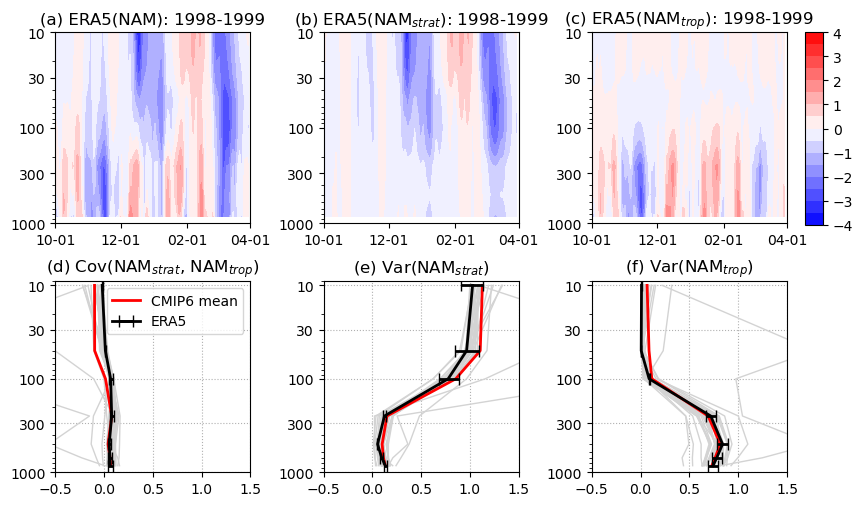

In [13]:
# colors = plt.cm.tab20c(np.linspace(0, 1, len(D_list)))

cm = 'bwr' # 'RdBu_r' # 'seismic' # 
fig = plt.figure(figsize=(9, 5.5))
mpl.rcParams.update({'font.size': 10})

cmax, cnum = 4, 9
ax1 = fig.add_subplot(2, 3, 1)
plot_snapshot(f"(a) ERA5(NAM): {year}-{year+1}", p0, D0.y2[yi, :offset+len_slice, :])

ax1 = fig.add_subplot(2, 3, 2)
plot_snapshot(r"(b) ERA5(NAM$_{strat}$): " + f"{year}-{year+1}", p0, D0.y2_strat[yi, :offset+len_slice, :])

ax1 = fig.add_subplot(2, 3, 3)
y2_trop = D0.y2 - D0.y2_strat
plot_snapshot(r"(c) ERA5(NAM$_{trop}$): " + f"{year}-{year+1}", p0, y2_trop[yi, :offset+len_slice, :])

ax1 = fig.add_subplot(2, 3, 4)
xerr = [r2_strat_trop0 - ci2[0].r2_strat_trop, ci2[1].r2_strat_trop - r2_strat_trop0]
plt.errorbar(r2_strat_trop0, p0, xerr=xerr, color='k', linewidth=2, capsize=4, zorder=30, label=D0.data.name)
for i in range(len(r2_strat_trop)):
    plt.plot(np.squeeze(r2_strat_trop[i]).T, p, color='lightgray', linewidth=1)
plt.plot(r2_strat_trop.mean(axis=0), p, color='r', linewidth=2, zorder=29, label=f'CMIP6 mean')
# plt.errorbar(r2_strat_trop.mean(axis=0), p, xerr=r2_strat_trop.std(axis=0), color='r', linewidth=2,  capsize=markersize/2, mfc='none', label=f'CMIP6 mean')

plt.ylim((9, 1000))
plt.gca().invert_yaxis()
plt.yscale('log')
plt.yticks([10, 30, 100, 300, 1000])
plt.xticks([-0.5, 0, 0.5, 1.0, 1.5])
plt.xlim((-0.5, 1.5))
plt.grid(linestyle=':')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.title(r'(d) Cov(NAM$_{strat}$, NAM$_{trop}$)')
plt.legend()

ax1 = fig.add_subplot(2, 3, 5)
xerr = [r2_strat0 - ci2[0].r2_strat, ci2[1].r2_strat - r2_strat0]
plt.errorbar(r2_strat0, p0, xerr=xerr, color='k', linewidth=2, capsize=4, zorder=30, label=D0.data.name)
for i in range(len(r2_strat)):
    plt.plot(np.squeeze(r2_strat[i]).T, p, color='lightgray', linewidth=1)
plt.plot(r2_strat.mean(axis=0), p, color='r', linewidth=2, zorder=29, label=f'CMIP6 mean')
# plt.errorbar(r2_strat.mean(axis=0), p, xerr=r2_strat.std(axis=0), color='r', linewidth=2,  capsize=markersize/2, mfc='none', label=f'CMIP6 mean')
# plt.plot(r2_strat0, p0, color='k', linewidth=2, label=D0.data.name)

plt.ylim((9, 1000))
plt.gca().invert_yaxis()
plt.yscale('log')
plt.yticks([10, 30, 100, 300, 1000])
plt.xticks([-0.5, 0, 0.5, 1.0, 1.5])
plt.xlim((-0.5, 1.5))
plt.grid(linestyle=':')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.title(r'(e) Var(NAM$_{strat}$)')
# plt.legend()

ax1 = fig.add_subplot(2, 3, 6)
xerr = [r2_trop0 - ci2[0].r2_trop, ci2[1].r2_trop - r2_trop0]
plt.errorbar(r2_trop0, p0, xerr=xerr, color='k', linewidth=2, capsize=4, zorder=30, label=D0.data.name)
for i in range(len(r2_trop)):
    plt.plot(np.squeeze(r2_trop[i]).T, p, color='lightgray', linewidth=1)
plt.plot(r2_trop.mean(axis=0), p, color='r', linewidth=2, zorder=29, label=f'CMIP6 mean')
# plt.errorbar(r2_trop.mean(axis=0), p, xerr=r2_trop.std(axis=0), color='r', linewidth=2,  capsize=markersize/2, mfc='none', label=f'CMIP6 mean')
# plt.plot(r2_trop0, p0, color='k', linewidth=2, label=D0.data.name)

plt.ylim((9, 1000))
plt.gca().invert_yaxis()
plt.yscale('log')
plt.yticks([10, 30, 100, 300, 1000])
plt.xticks([-0.5, 0, 0.5, 1.0, 1.5])
plt.xlim((-0.5, 1.5))
plt.grid(linestyle=':')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.title(r'(f) Var(NAM$_{trop}$)')
# plt.legend()

plt.tight_layout()
# # bottom colorbar
# # fig.subplots_adjust(bottom=0.2)
# # cax = fig.add_axes([0.12, 0.1, 0.80, 0.04])    #[left, bottom, width, height]
# cax = fig.add_axes([0.03, 0.45, 0.30, 0.04])    #[left, bottom, width, height]
# cbar = plt.colorbar(cax=cax, orientation='horizontal')
# cbar.set_ticks(np.linspace(-cmax, cmax, cnum))
# vertical colorbar
fig.subplots_adjust(bottom=0.1, right=0.88, top=0.9)
cax = fig.add_axes([0.90, 0.55, 0.02, 0.35])    #[left, bottom, width, height]
cbar = plt.colorbar(cax=cax, orientation='vertical')
cbar.set_ticks(np.linspace(-cmax, cmax, cnum))

# plt.savefig('Figs/AM_event_ERA5_snapshot.pdf', transparent=True)

MIROC-ES2L
UKESM1


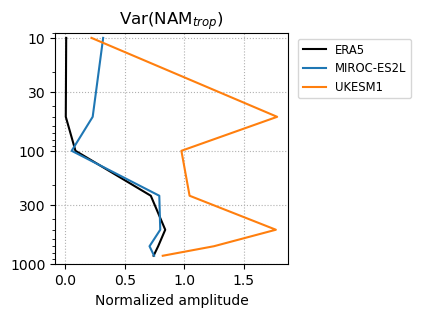

In [14]:
for i in range(len(r2_strat)):
    if r2_strat[i][np.array(p)==50] > 1.4:
        print(model_list[i])
# plt.plot(r2_strat.T, p)

fig = plt.figure(figsize=(3,3))
# for idx, D in enumerate(D_list):
#     if not D.complex_strat:
#         plt.plot(r2_trop[idx,:],p, label=D_list[idx].data.name)
plt.plot(r2_trop0, p0, '-k', label=D0.data.name)
# idx = model_list.index('MIROC-ES2L')
# plt.plot(r2_strat_trop[idx,:],p, label=D_list[idx].data.name)
# idx = model_list.index('GFDL-ESM4')
# plt.plot(r2_strat_trop[idx,:],p, label=D_list[idx].data.name)
# idx = model_list.index('HadGEM3-GC31-LL')
# plt.plot(r2_strat_trop[idx,:],p, label=D_list[idx].data.name)
# idx = model_list.index('CanESM5')
# plt.plot(r2_strat_trop[idx,:],p, label=D_list[idx].data.name)
idx = model_list.index('MIROC-ES2L')
plt.plot(r2_trop[idx,:],p, label=D_list[idx].data.name)
idx = model_list.index('UKESM1')
plt.plot(r2_trop[idx,:],p, label=D_list[idx].data.name)

plt.ylim((9, 1000))
plt.gca().invert_yaxis()
plt.xlabel('Normalized amplitude')
# plt.ylabel('Pressure (hPa)')
# plt.xlim((-2, 2))
# plt.xticks([-2, -1, 0, 1, 2])
plt.yscale('log')
plt.yticks([10, 30, 100, 300, 1000])
plt.grid(linestyle=':')
plt.title('Var(NAM$_{trop}$)')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.legend(fontsize='small', bbox_to_anchor=(1.02, 1))

In [15]:
print('p:', p0, '\n trop:', r2_trop0, '\n strat:', r2_strat0, '\n cross:', r2_strat_trop0, '\n sum:', r2_trop0+r2_strat0+2*r2_strat_trop0)

p: [ 10.  50. 100. 250. 500. 700. 850.] 
 trop: [0.00933498 0.00599822 0.08706557 0.71868093 0.83970261 0.78042856
 0.74191007] 
 strat: [1.02752949 0.96637619 0.7771736  0.12403641 0.05384952 0.09639508
 0.13377904] 
 cross: [-0.01843032  0.01381657  0.06788454  0.07864307  0.05325057  0.06163322
  0.06220931] 
 sum: [1.00000383 1.00000754 1.00000825 1.00000348 1.00005326 1.00009007
 1.00010774]


## Event composites

In [16]:
lag_time = 40
threshold = -2
lags = np.arange(lag_time+1)
lags2= range(-lag_time, lag_time+1)
p_level2 = 850

def find_event_y2(y, p0, y2, y2_strat):
    y2_event0, y2_num0 = find_event(y, p0, y2=y2, threshold=threshold, lag_time=lag_time)
    y2_strat_event0, y2_num0 = find_event(y, p0, y2=y2_strat, threshold=threshold, lag_time=lag_time)

    k = np.isin(p0, p_level2)
    y2_k_event0 = y2_event0[:, k]
    y2_strat_k_event0 = y2_strat_event0[:, k]
    return y2_event0, y2_strat_event0, y2_num0, y2_k_event0, y2_strat_k_event0

def find_event_y3(y3, p0, y3_strat, get_ci=False):
    if get_ci: 
        y3_event0_all, y3_num0 = find_event(y3[None, lag_time:-lag_time], p0, y2=y3[None,:], threshold=threshold, lag_time=lag_time, event_mean=False)
        y3_event0 = y3_event0_all.mean(axis=0)
    else:
        y3_event0, y3_num0 = find_event(y3[None, lag_time:-lag_time], p0, y2=y3[None,:], threshold=threshold, lag_time=lag_time)
    y3_strat_event0, y3_num0 = find_event(y3[None, lag_time:-lag_time], p0, y2=y3_strat[None,:], threshold=threshold, lag_time=lag_time)

    k = np.isin(p0, p_level2)
    y3_k_event0 = y3_event0[:, k]
    y3_strat_k_event0 = y3_strat_event0[:, k]

    if get_ci:
        from collections import namedtuple
        
        y3_k_event0_all = np.squeeze(y3_event0_all[:,:,k])
        
        res = stats.bootstrap((y3_event0_all,), np.mean, n_resamples=1000, batch=round(y3_num0/1000*64), confidence_level=0.95, random_state=42)
        dis_all = res.bootstrap_distribution
        ci_all = res.confidence_interval

        res = stats.bootstrap((y3_k_event0_all,), np.mean, n_resamples=1000, batch=round(y3_num0/1000*64), confidence_level=0.95, random_state=42)
        dis_k_all = res.bootstrap_distribution
        ci_k_all = res.confidence_interval
        
        arr_dict = {'y3_event': dis_all, 'y3_k_event': dis_k_all}
        dis = namedtuple('array', arr_dict.keys())(**arr_dict)

        arr_dict = {'y3_event': ci_all[0], 'y3_k_event': ci_k_all[0]}
        ci_low = namedtuple('low', arr_dict.keys())(**arr_dict)
        arr_dict = {'y3_event': ci_all[1], 'y3_k_event': ci_k_all[1]}
        ci_high = namedtuple('high', arr_dict.keys())(**arr_dict)
        ci = (ci_low, ci_high)

        return  y3_event0, y3_strat_event0, y3_num0, y3_k_event0, y3_strat_k_event0, ci, dis
    else:
        return  y3_event0, y3_strat_event0, y3_num0, y3_k_event0, y3_strat_k_event0

y2_event0, y2_strat_event0, y2_num0, y2_k_event0, y2_strat_k_event0 = find_event_y2(D0.y, p0, D0.y2, D0.y2_strat)
y3_event0, y3_strat_event0, y3_num0, y3_k_event0, y3_strat_k_event0, ci3r, dis3r = find_event_y3(D0.y3, p0, D0.y3_strat, get_ci=True)

y2_event = np.empty((len(D_list), *y2_event0.shape))
y2_strat_event = np.empty((len(D_list), *y2_strat_event0.shape))
y2_num = np.empty((len(D_list)))
y3_event = np.empty((len(D_list), *y3_event0.shape))
y3_strat_event = np.empty((len(D_list), *y3_strat_event0.shape))
y3_num = np.empty((len(D_list)))

y2_k_event = np.empty((len(D_list), *y2_k_event0.shape))
y2_strat_k_event = np.empty((len(D_list), *y2_strat_k_event0.shape))
y3_k_event = np.empty((len(D_list), *y3_k_event0.shape))
y3_strat_k_event = np.empty((len(D_list), *y3_strat_k_event0.shape))

for i, D in enumerate(D_list):
    print(f'==================== {D.data.name} ====================')
    y2_event[i], y2_strat_event[i], y2_num[i], y2_k_event[i], y2_strat_k_event[i] = find_event_y2(D.y, p, D.y2, D.y2_strat)
    y3_event[i], y3_strat_event[i], y3_num[i], y3_k_event[i], y3_strat_k_event[i] = find_event_y3(D.y3, p, D.y3_strat)

# of events: 35(0.55)
# of events: 35(0.55)
# of events: 402(402.00)
# of events: 402(402.00)
==================== ACCESS-CM2 ====================
# of events: 31(0.48)
# of events: 31(0.48)
# of events: 350(350.00)
# of events: 350(350.00)
==================== BCC-ESM1 ====================
# of events: 37(0.58)
# of events: 37(0.58)
# of events: 521(521.00)
# of events: 521(521.00)
==================== CanESM5 ====================
# of events: 37(0.58)
# of events: 37(0.58)
# of events: 326(326.00)
# of events: 326(326.00)
==================== CESM2 ====================
# of events: 42(0.66)
# of events: 42(0.66)
# of events: 395(395.00)
# of events: 395(395.00)
==================== CESM2-WACCM ====================
# of events: 46(0.72)
# of events: 46(0.72)
# of events: 507(507.00)
# of events: 507(507.00)
==================== CNRM-CM6 ====================
# of events: 35(0.55)
# of events: 35(0.55)
# of events: 382(382.00)
# of events: 382(382.00)
==================== CNRM-CM6-HR ==

In [17]:
Stack_LIM3 = StackArray()

def stat_func(yy, axis):
    y, y2, y2_strat = yy[:, :150, :], yy[:, 150:380, :], yy[:, 380:, :]
    y2_event0, y2_strat_event0, _, y2_k_event0, y2_strat_k_event0 = find_event_y2(y, p0, y2, y2_strat)
    Stack_LIM3.add_array('y2_event', y2_event0)
    Stack_LIM3.add_array('y2_strat_event', y2_strat_event0)
    Stack_LIM3.add_array('y2_k_event', y2_k_event0)
    Stack_LIM3.add_array('y2_strat_k_event', y2_strat_k_event0)
    return Stack_LIM3.stack()

ci_stacked, dis_stacked, se_stacked = bootstrap(np.hstack((D0.y, D0.y2, D0.y2_strat)), statistic=stat_func, n_resamples=1000, confidence_level=0.95, random_state=42, method='percentile')

ci3 = (Stack_LIM3.unstack(ci_stacked[0], 'low'), Stack_LIM3.unstack(ci_stacked[1], 'high'))
dis3 = Stack_LIM3.unstack(dis_stacked, axis=1)

# of events: 41(0.64)
# of events: 41(0.64)
# of events: 35(0.55)
# of events: 35(0.55)
# of events: 30(0.47)
# of events: 30(0.47)
# of events: 35(0.55)
# of events: 35(0.55)
# of events: 37(0.58)
# of events: 37(0.58)
# of events: 36(0.56)
# of events: 36(0.56)
# of events: 39(0.61)
# of events: 39(0.61)
# of events: 42(0.66)
# of events: 42(0.66)
# of events: 40(0.62)
# of events: 40(0.62)
# of events: 36(0.56)
# of events: 36(0.56)
# of events: 28(0.44)
# of events: 28(0.44)
# of events: 34(0.53)
# of events: 34(0.53)
# of events: 35(0.55)
# of events: 35(0.55)
# of events: 42(0.66)
# of events: 42(0.66)
# of events: 33(0.52)
# of events: 33(0.52)
# of events: 39(0.61)
# of events: 39(0.61)
# of events: 35(0.55)
# of events: 35(0.55)
# of events: 30(0.47)
# of events: 30(0.47)
# of events: 38(0.59)
# of events: 38(0.59)
# of events: 37(0.58)
# of events: 37(0.58)
# of events: 36(0.56)
# of events: 36(0.56)
# of events: 37(0.58)
# of events: 37(0.58)
# of events: 30(0.47)
# of event

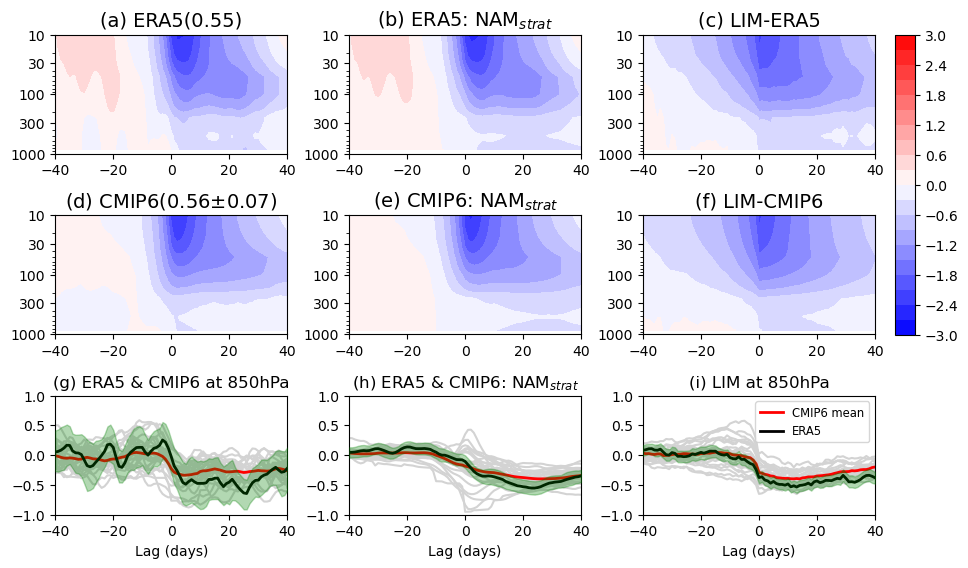

In [18]:
def plot_event(name, p, y0_event):
    plt.contourf(lags2, p, y0_event.T, np.linspace(-cmax, cmax, cnum*2-1), cmap=cm)
    # plt.plot(np.zeros_like(p), p, '-k')
    plt.gca().invert_yaxis()
    plt.yscale('log')
    plt.yticks([10, 30, 100, 300, 1000])
    # plt.ylabel('hPa')
    plt.xticks([-40, -20, 0, 20, 40])
    # plt.xlabel('Lag (days)')
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title(name, fontsize=14)

cm = 'bwr' # 'RdBu_r' # 'seismic' # 
fig = plt.figure(figsize=(10,6))
mpl.rcParams.update({'font.size': 10})

y_total = 2014-1950
cmax, cnum = 3, 11
ax1 = fig.add_subplot(3, 3, 1)
plot_event(f"(a) ERA5({y2_num0/y_total:.2f})", p0, y2_event0)

ax1 = fig.add_subplot(3, 3, 4)
plot_event(f"(d) CMIP6({y2_num.mean(axis=0)/y_total:.2f}" + r"$\pm$" + f"{y2_num.std(axis=0)/y_total:.2f})", p, y2_event.mean(axis=0))

ax1 = fig.add_subplot(3, 3, 2)
plot_event(f"(b) ERA5"+r": NAM$_{strat}$", p0, y2_strat_event0)

ax1 = fig.add_subplot(3, 3, 5)
plot_event(f"(e) CMIP6"+r": NAM$_{strat}$", p, y2_strat_event.mean(axis=0))

ax1 = fig.add_subplot(3, 3, 3)
# plot_event(f"LIM-ERA5({y3_num0/1e3:.2f})", p0, y3_event0)
plot_event(f"(c) LIM-ERA5", p0, y3_event0)

ax1 = fig.add_subplot(3, 3, 6)
# plot_event(f"LIM-CMIP6({y3_num.mean(axis=0)/1e3:.2f}" + r"$\pm$" + f"{y3_num.std(axis=0)/1e3:.2f})", p, y3_event.mean(axis=0))
plot_event(f"(f) LIM-CMIP6", p, y3_event.mean(axis=0))

ax1 = fig.add_subplot(3, 3, 7)
ax1.plot(lags2, np.squeeze(y2_k_event).T, color='lightgray')
ax1.plot(lags2, y2_k_event.mean(axis=0), color='r', linewidth=2, label=f'CMIP6({len(D_list)})')
ax1.plot(lags2, y2_k_event0, color='k', linewidth=2, label=D0.data.name)
plt.fill_between(lags2, ci3[0].y2_k_event, ci3[1].y2_k_event, color='green', zorder=5, alpha=0.3)
plt.xticks([-40, -20, 0, 20, 40])
ax1.set_xlim((-40, 40))
ax1.set_ylim((-1.0, 1.0))
plt.xlabel('Lag (days)')
plt.title(f'(g) ERA5 & CMIP6 at {p_level2:.0f}hPa')
# ax1.legend()

ax1 = fig.add_subplot(3, 3, 8)
ax1.plot(lags2, np.squeeze(y2_strat_k_event).T, color='lightgray')
ax1.plot(lags2, y2_strat_k_event.mean(axis=0), color='r', linewidth=2, label='CMIP6 mean')
ax1.plot(lags2, y2_strat_k_event0, color='k', linewidth=2, label=D0.data.name)
plt.fill_between(lags2, ci3[0].y2_strat_k_event, ci3[1].y2_strat_k_event, color='green', zorder=5, alpha=0.3)
plt.xticks([-40, -20, 0, 20, 40])
ax1.set_xlim((-40, 40))
ax1.set_ylim((-1.0, 1.0))
plt.xlabel('Lag (days)')
plt.title(f"(h) ERA5 & CMIP6"+r": NAM$_{strat}$")
# ax1.legend()

ax1 = fig.add_subplot(3, 3, 9)
ax1.plot(lags2, np.squeeze(y3_k_event).T, color='lightgray')
ax1.plot(lags2, y3_k_event.mean(axis=0), color='r', linewidth=2, label=f'CMIP6 mean')
ax1.plot(lags2, y3_k_event0, color='k', linewidth=2, label=D0.data.name)
plt.fill_between(lags2, ci3r[0].y3_k_event, ci3r[1].y3_k_event, color='green', zorder=5, alpha=0.3)
plt.xticks([-40, -20, 0, 20, 40])
ax1.set_xlim((-40, 40))
ax1.set_ylim((-1.0, 1.0))
plt.xlabel('Lag (days)')
ax1.legend(fontsize='small')
plt.title(f'(i) LIM at {p_level2:.0f}hPa')

plt.tight_layout()
# fig.subplots_adjust(bottom=0.22)
# cax = fig.add_axes([0.12, 0.1, 0.80, 0.04])    #[left, bottom, width, height]
# cbar = plt.colorbar(cax=cax, orientation='horizontal')
# cbar.set_ticks(np.linspace(-cmax, cmax, cnum))
fig.subplots_adjust(bottom=0.1, right=0.88, top=0.9)
cax = fig.add_axes([0.90, 0.4, 0.02, 0.5])    #[left, bottom, width, height]
cbar = plt.colorbar(cax=cax, orientation='vertical')
cbar.set_ticks(np.linspace(-cmax, cmax, cnum))

# plt.savefig('Figs/AM_event_cmip6_LIM.pdf', transparent=True)

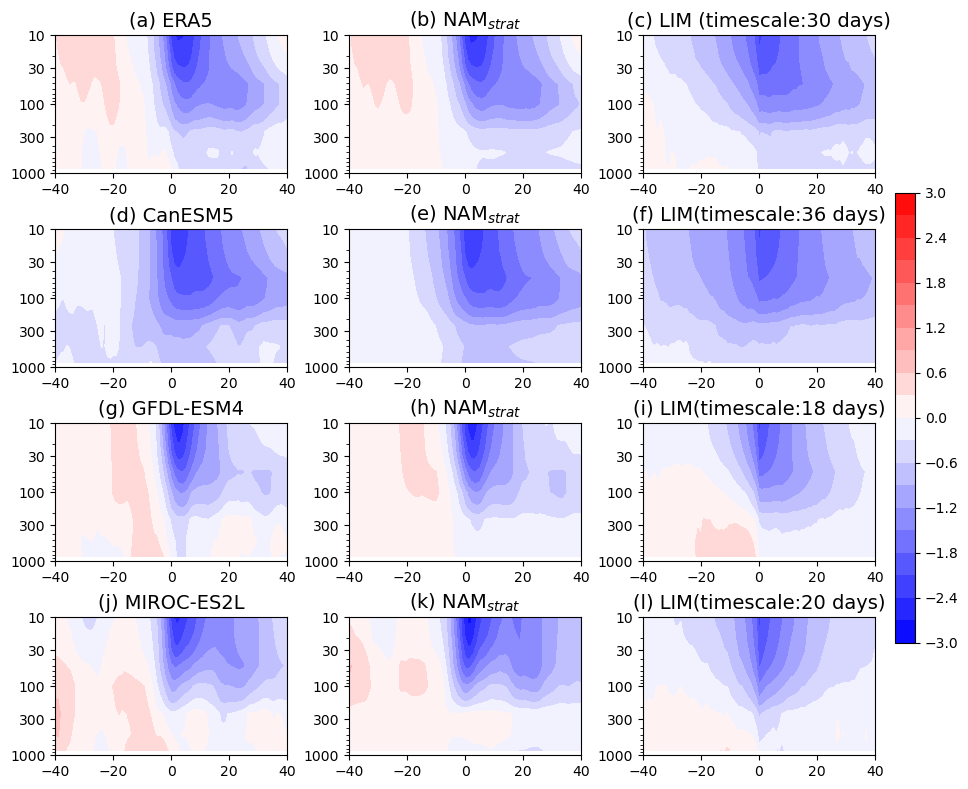

In [19]:
def plot_event(name, p, y0_event):
    plt.contourf(lags2, p, y0_event.T, np.linspace(-cmax, cmax, cnum*2-1), cmap=cm)
    # plt.plot(np.zeros_like(p), p, '-k')
    plt.gca().invert_yaxis()
    plt.yscale('log')
    plt.yticks([10, 30, 100, 300, 1000])
    # plt.ylabel('hPa')
    plt.xticks([-40, -20, 0, 20, 40])
    # plt.xlabel('Lag (days)')
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title(name, fontsize=14)

def plot_model(model_name, row):
    i = model_list.index(model_name)
    D = D_list[i]

    ax1 = fig.add_subplot(4, 3, row*3-2)
    plot_event(f"({chr(ord('a')+row*3-3)}) {D.data.name}", p, y2_event[i])

    ax1 = fig.add_subplot(4, 3, row*3-1)
    plot_event(f"({chr(ord('b')+row*3-3)}) "+ r"NAM$_{strat}$", p, y2_strat_event[i])

    ax1 = fig.add_subplot(4, 3, row*3)
    plot_event(f"({chr(ord('c')+row*3-3)}) LIM"+f"(timescale:{-1/D.model.b[0].real:.0f} days)", p, y3_event[i])

cm = 'bwr' # 'RdBu_r' # 'seismic' # 
fig = plt.figure(figsize=(10,9))
mpl.rcParams.update({'font.size': 10})

cmax, cnum = 3, 11
ax1 = fig.add_subplot(4, 3, 1)
plot_event(f"(a) {D0.data.name}", p0, y2_event0)
ax1 = fig.add_subplot(4, 3, 2)
plot_event(r"(b) NAM$_{strat}$", p0, y2_strat_event0)
ax1 = fig.add_subplot(4, 3, 3)
plot_event(f"(c) LIM"+f" (timescale:{-1/D0.model.b[0].real:.0f} days)", p0, y3_event0)

# plot_model("HadGEM3-GC31-LL", row=2)
plot_model("CanESM5", row=2)
plot_model("GFDL-ESM4", row=3)
plot_model("MIROC-ES2L", row=4)

plt.tight_layout()
# fig.subplots_adjust(bottom=0.22)
# cax = fig.add_axes([0.12, 0.1, 0.80, 0.04])    #[left, bottom, width, height]
# cbar = plt.colorbar(cax=cax, orientation='horizontal')
# cbar.set_ticks(np.linspace(-cmax, cmax, cnum))
fig.subplots_adjust(bottom=0.1, right=0.88, top=0.9)
cax = fig.add_axes([0.90, 0.225, 0.02, 0.5])    #[left, bottom, width, height]
cbar = plt.colorbar(cax=cax, orientation='vertical')
cbar.set_ticks(np.linspace(-cmax, cmax, cnum))

# plt.savefig('Figs/AM_event_cmip6_LIM2.pdf', transparent=True)

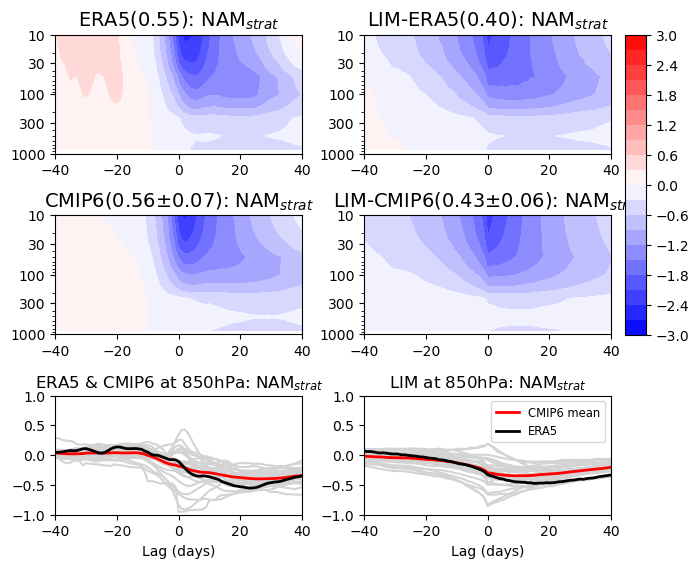

In [20]:
cm = 'bwr' # 'RdBu_r' # 'seismic' # 
fig = plt.figure(figsize=(7,6))
mpl.rcParams.update({'font.size': 10})

y_total = 2014-1950
cmax, cnum = 3, 11
ax1 = fig.add_subplot(3, 2, 1)
plot_event(f"ERA5({y2_num0/y_total:.2f})"+r": NAM$_{strat}$", p0, y2_strat_event0)

ax1 = fig.add_subplot(3, 2, 3)
plot_event(f"CMIP6({y2_num.mean(axis=0)/y_total:.2f}" + r"$\pm$" + f"{y2_num.std(axis=0)/y_total:.2f})"+r": NAM$_{strat}$", p, y2_strat_event.mean(axis=0))

ax1 = fig.add_subplot(3, 2, 2)
plot_event(f"LIM-ERA5({y3_num0/1e3:.2f})"+r": NAM$_{strat}$", p0, y3_strat_event0)

ax1 = fig.add_subplot(3, 2, 4)
plot_event(f"LIM-CMIP6({y3_num.mean(axis=0)/1e3:.2f}" + r"$\pm$" + f"{y3_num.std(axis=0)/1e3:.2f})"+r": NAM$_{strat}$", p, y3_strat_event.mean(axis=0))

ax1 = fig.add_subplot(3, 2, 5)
ax1.plot(lags2, np.squeeze(y2_strat_k_event).T, color='lightgray')
ax1.plot(lags2, y2_strat_k_event.mean(axis=0), color='r', linewidth=2, label='CMIP6 mean')
ax1.plot(lags2, y2_strat_k_event0, color='k', linewidth=2, label=D0.data.name)
plt.xticks([-40, -20, 0, 20, 40])
ax1.set_xlim((-lag_time, lag_time))
ax1.set_ylim((-1.0, 1.0))
plt.xlabel('Lag (days)')
plt.title(f"ERA5 & CMIP6 at {p_level2:.0f}hPa"+r": NAM$_{strat}$")
# ax1.legend()

ax1 = fig.add_subplot(3, 2, 6)
ax1.plot(lags2, np.squeeze(y3_strat_k_event).T, color='lightgray')
ax1.plot(lags2, y3_strat_k_event.mean(axis=0), color='r', linewidth=2, label='CMIP6 mean')
ax1.plot(lags2, y3_strat_k_event0, color='k', linewidth=2, label=D0.data.name)
plt.xticks([-40, -20, 0, 20, 40])
ax1.set_xlim((-lag_time, lag_time))
ax1.set_ylim((-1.0, 1.0))
plt.xlabel('Lag (days)')
ax1.legend(fontsize='small')
plt.title(f"LIM at {p_level2:.0f}hPa"+r": NAM$_{strat}$")

plt.tight_layout()
# fig.subplots_adjust(bottom=0.22)
# cax = fig.add_axes([0.12, 0.1, 0.80, 0.04])    #[left, bottom, width, height]
# cbar = plt.colorbar(cax=cax, orientation='horizontal')
# cbar.set_ticks(np.linspace(-cmax, cmax, cnum))
fig.subplots_adjust(bottom=0.1, right=0.88, top=0.9)
cax = fig.add_axes([0.90, 0.4, 0.03, 0.5])    #[left, bottom, width, height]
cbar = plt.colorbar(cax=cax, orientation='vertical')
cbar.set_ticks(np.linspace(-cmax, cmax, cnum))

# plt.savefig('Figs/AM_event_strat_cmip6_LIM.pdf', transparent=True)

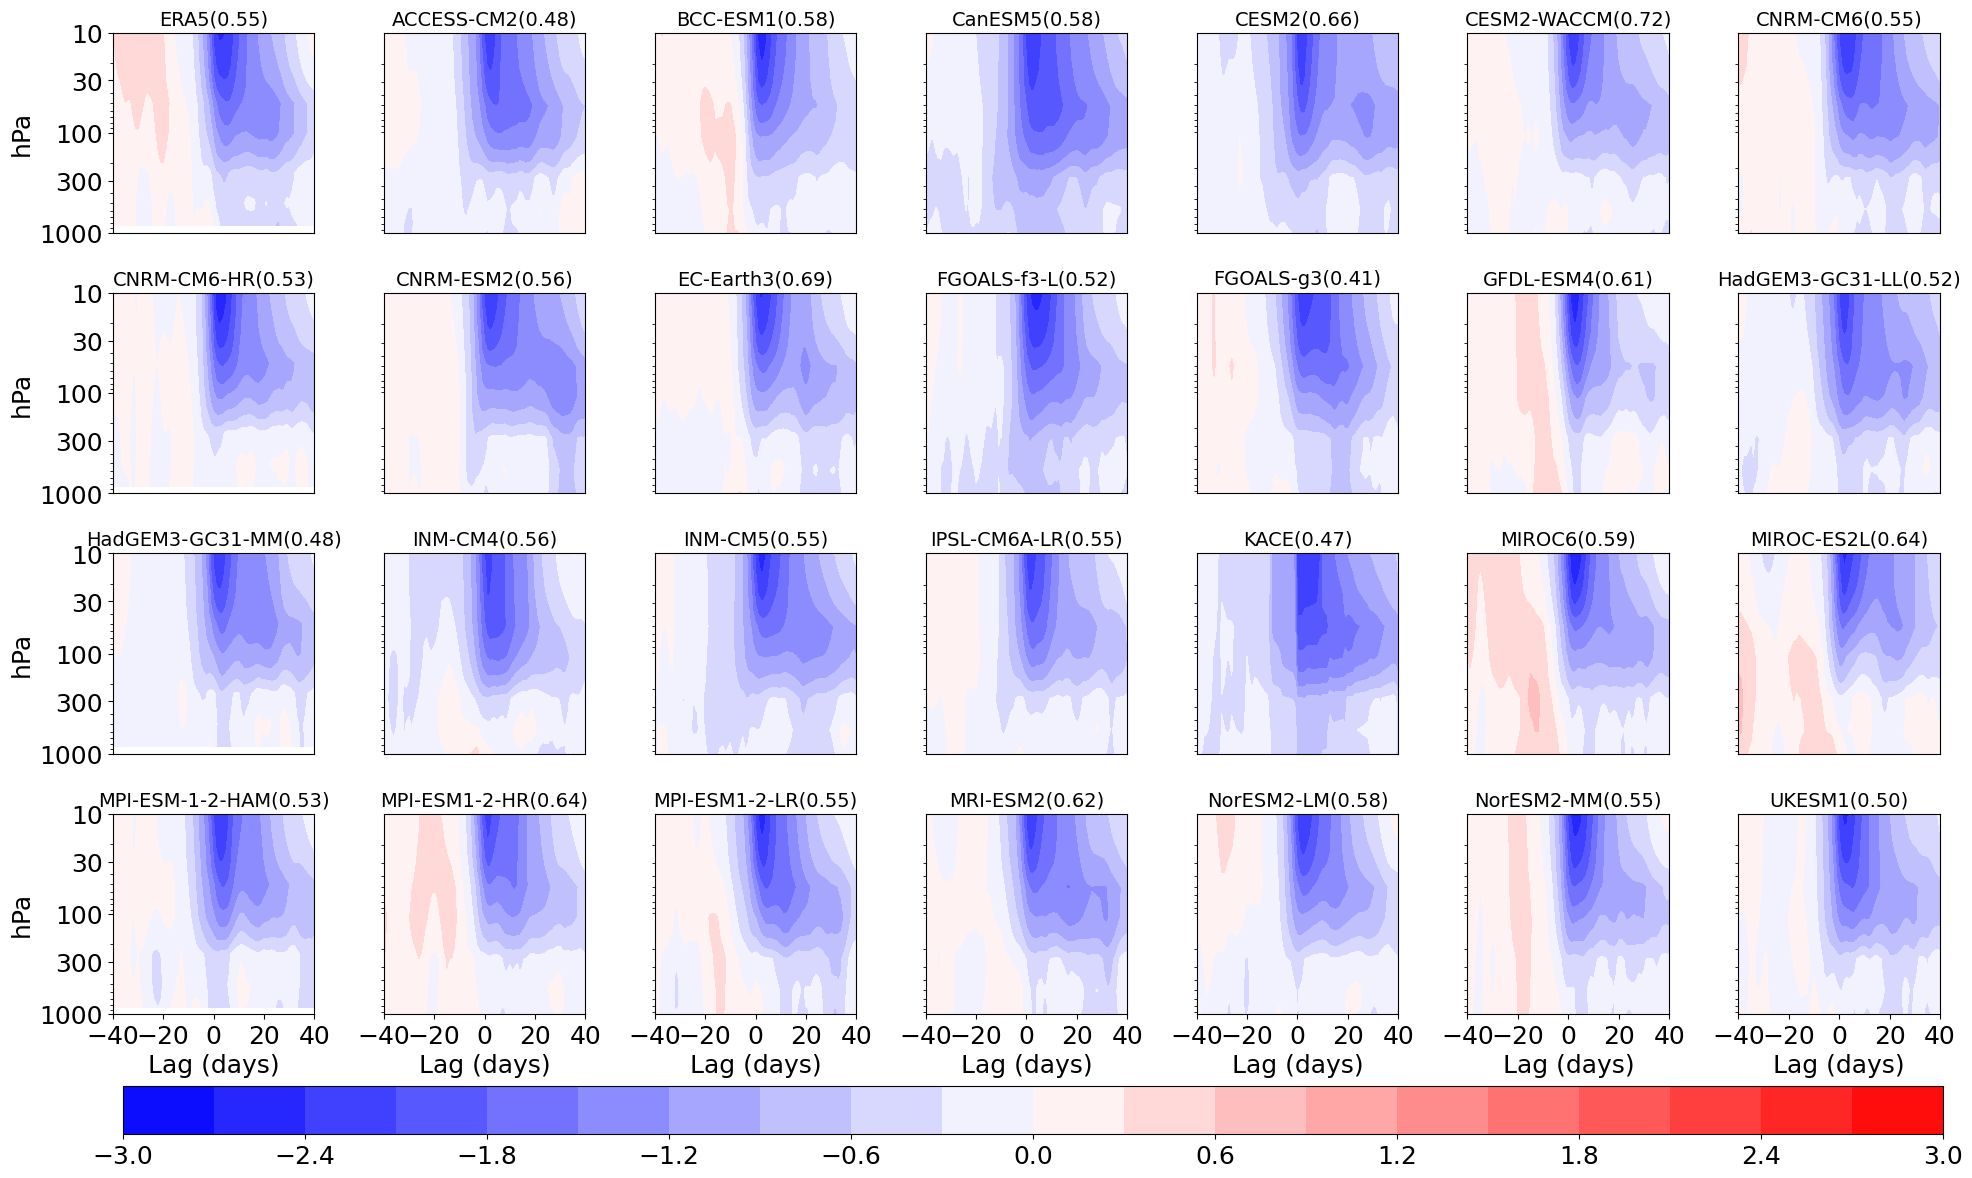

In [21]:
def plot_event2(name, p, y0_event, plot_i):
    plt.contourf(lags2, p, y0_event.T, np.linspace(-cmax, cmax, cnum*2-1), cmap=cm)
    plt.gca().invert_yaxis()
    plt.yscale('log')
    if plot_i % 7 == 0:
        plt.yticks([10, 30, 100, 300, 1000])
        plt.ylabel('hPa')
    else:
        plt.yticks([])
    if plot_i < 21:
        plt.xticks([])
    else:
        plt.xticks([-40, -20, 0, 20, 40])
        plt.xlabel('Lag (days)')
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title(name, fontsize=14)

cm = 'bwr' # 'RdBu_r' # 'seismic'
fig = plt.figure(figsize=(20,12))
mpl.rcParams.update({'font.size': 18})

cmax, cnum = 3, 11
ax1 = fig.add_subplot(4, 7, 1)
y_total = 2014-1950
plot_event2(f'ERA5({y2_num0/y_total:.2f})', D0.data.level, y2_event0, 0)

for i, D in enumerate(D_list):
    ax1 = fig.add_subplot(4, 7, i+2)
    plot_event2(f'{D.data.name}({y2_num[i]/y_total:.2f})', D.data.level, y2_event[i], i+1)

plt.tight_layout()
fig.subplots_adjust(bottom=0.14)
cax = fig.add_axes([0.07, 0.04, 0.91, 0.04])    #[left, bottom, width, height]
cbar = plt.colorbar(cax=cax, orientation='horizontal')
cbar.set_ticks(np.linspace(-cmax, cmax, cnum))

# plt.savefig('Figs/AM_event_all.pdf', transparent=True)

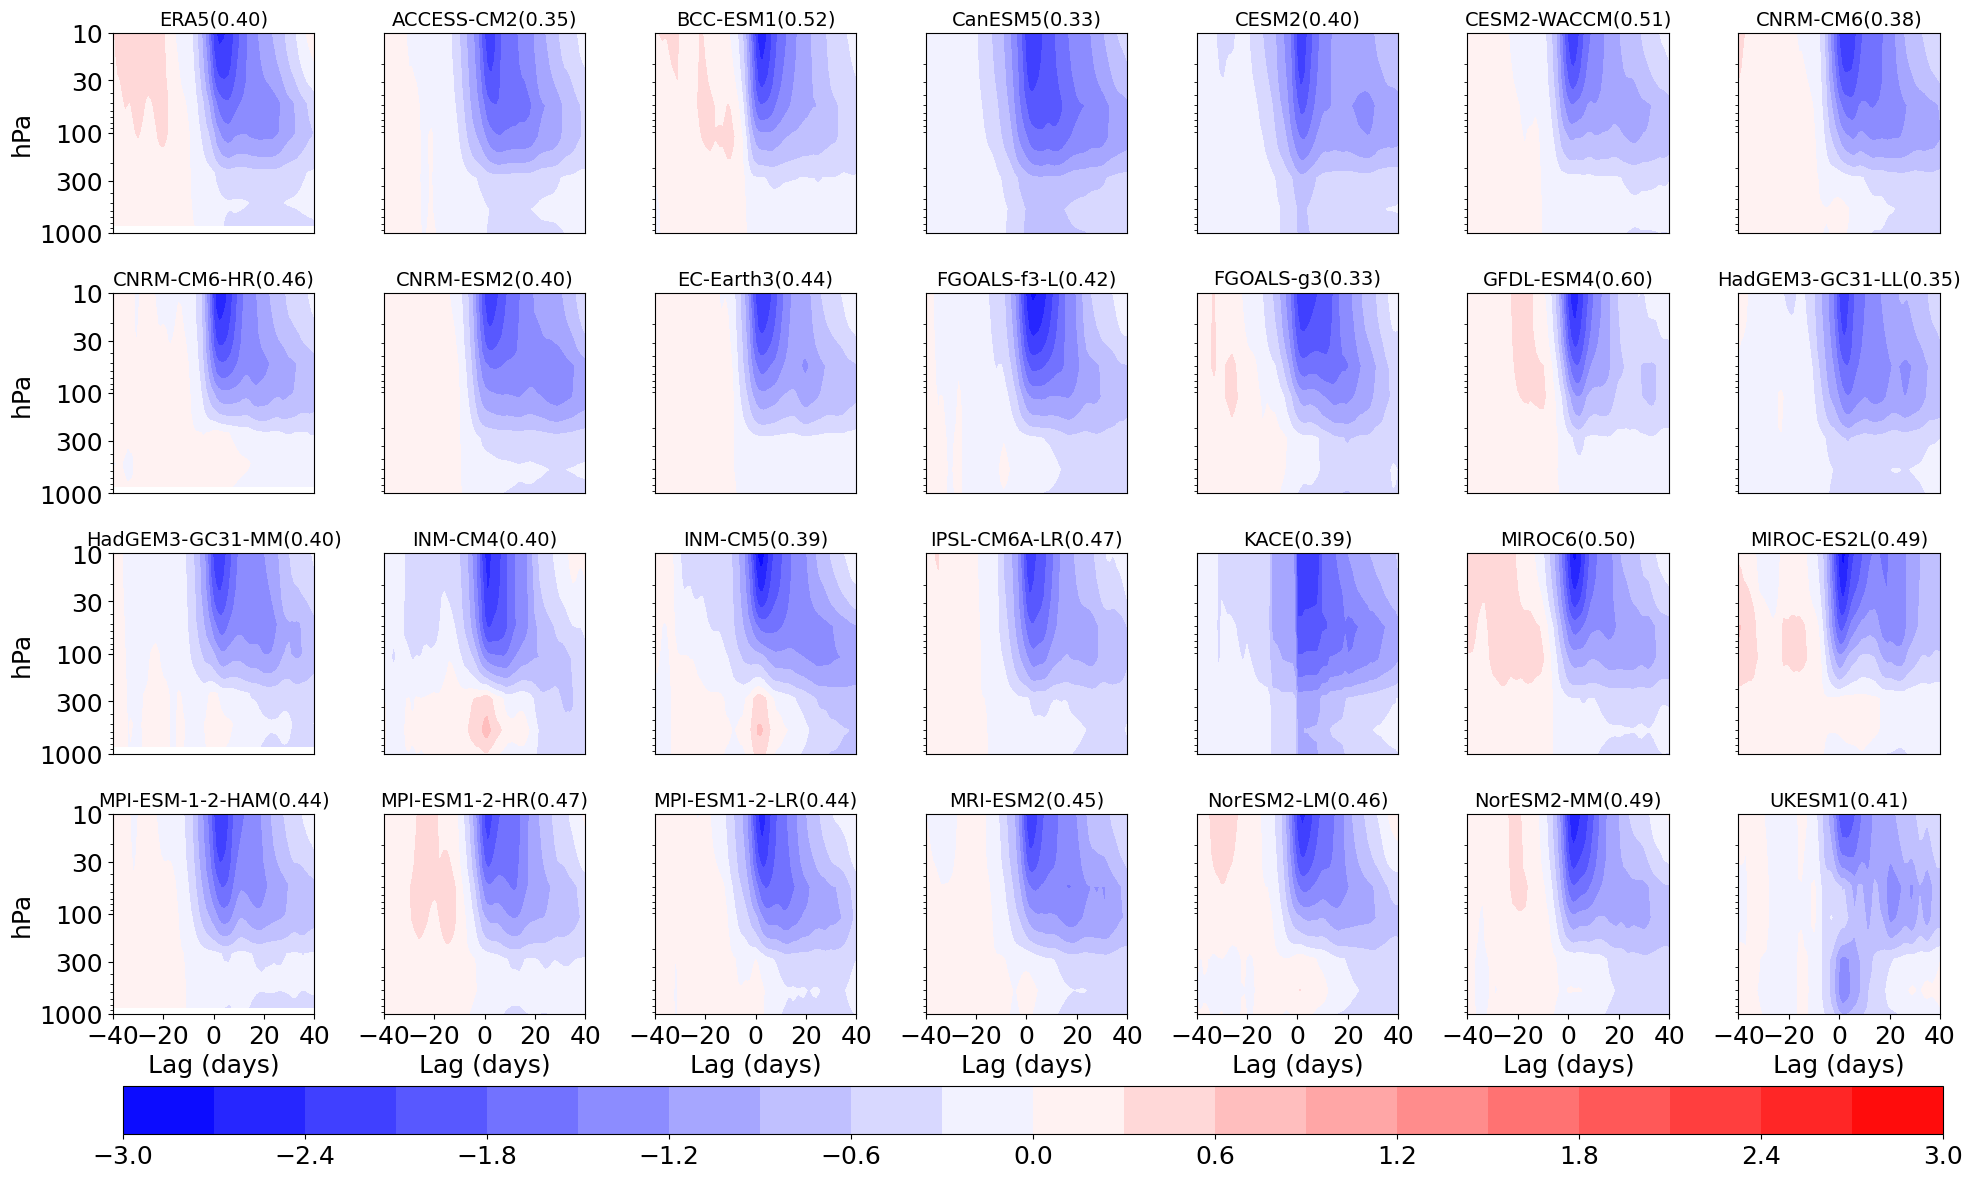

In [22]:
def plot_event2(name, p, y0_event, plot_i):
    plt.contourf(lags2, p, y0_event.T, np.linspace(-cmax, cmax, cnum*2-1), cmap=cm)
    plt.gca().invert_yaxis()
    plt.yscale('log')
    if plot_i % 7 == 0:
        plt.yticks([10, 30, 100, 300, 1000])
        plt.ylabel('hPa')
    else:
        plt.yticks([])
    if plot_i < 21:
        plt.xticks([])
    else:
        plt.xticks([-40, -20, 0, 20, 40])
        plt.xlabel('Lag (days)')
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title(name, fontsize=14)

cm = 'bwr' # 'RdBu_r' # 'seismic'
fig = plt.figure(figsize=(20,12))
mpl.rcParams.update({'font.size': 18})

cmax, cnum = 3, 11
ax1 = fig.add_subplot(4, 7, 1)
plot_event2(f'ERA5({y3_num0/1e3:.2f})', D0.data.level, y2_strat_event0, 0)

for i, D in enumerate(D_list):
    ax1 = fig.add_subplot(4, 7, i+2)
    plot_event2(f'{D.data.name}({y3_num[i]/1e3:.2f})', D.data.level, y2_strat_event[i], i+1)

plt.tight_layout()
fig.subplots_adjust(bottom=0.14)
cax = fig.add_axes([0.07, 0.04, 0.91, 0.04])    #[left, bottom, width, height]
cbar = plt.colorbar(cax=cax, orientation='horizontal')
cbar.set_ticks(np.linspace(-cmax, cmax, cnum))

# plt.savefig('Figs/AM_event_all_strat.pdf', transparent=True)

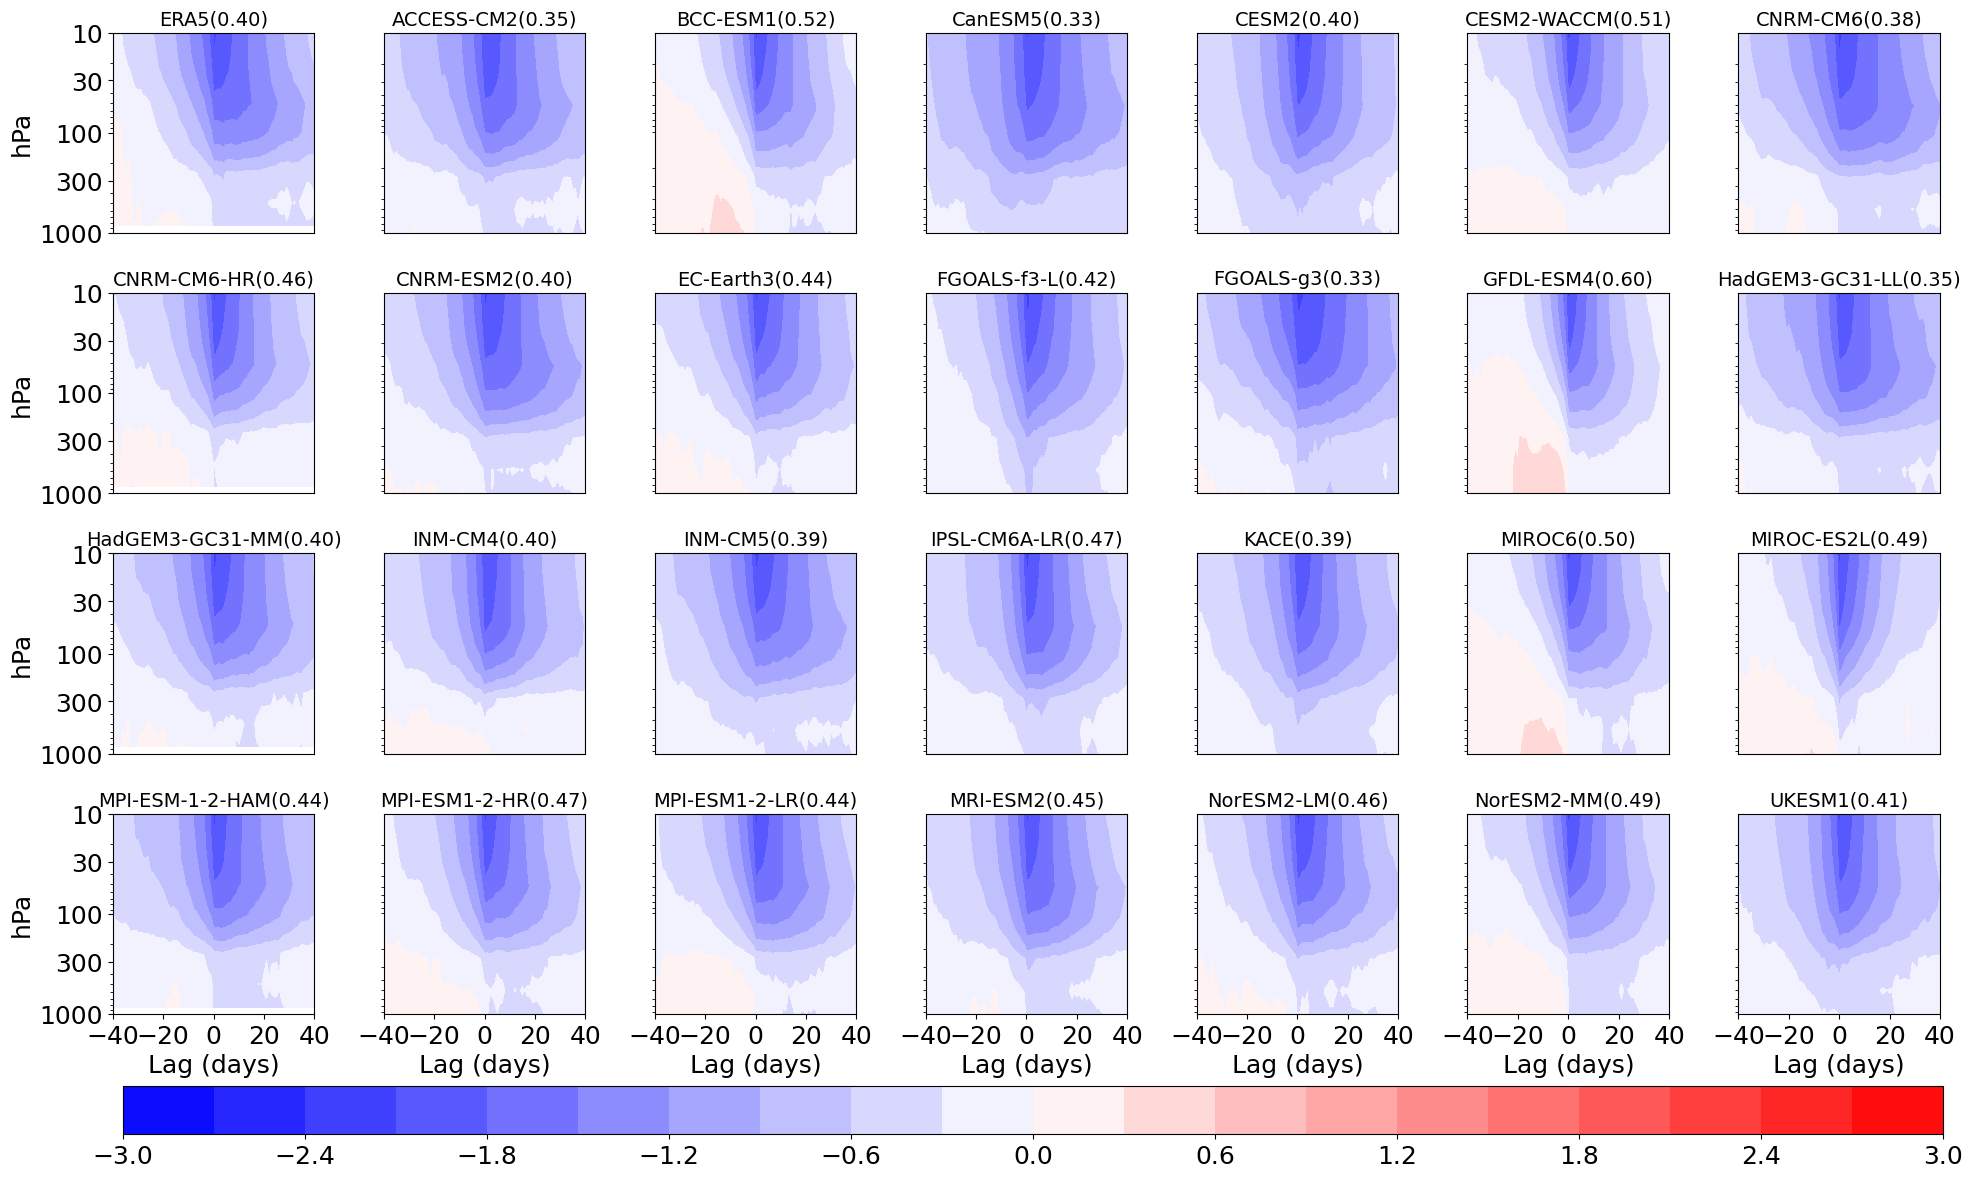

In [23]:
def plot_event2(name, p, y0_event, plot_i):
    plt.contourf(lags2, p, y0_event.T, np.linspace(-cmax, cmax, cnum*2-1), cmap=cm)
    plt.gca().invert_yaxis()
    plt.yscale('log')
    if plot_i % 7 == 0:
        plt.yticks([10, 30, 100, 300, 1000])
        plt.ylabel('hPa')
    else:
        plt.yticks([])
    if plot_i < 21:
        plt.xticks([])
    else:
        plt.xticks([-40, -20, 0, 20, 40])
        plt.xlabel('Lag (days)')
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title(name, fontsize=14)

cm = 'bwr' # 'RdBu_r' # 'seismic'
fig = plt.figure(figsize=(20,12))
mpl.rcParams.update({'font.size': 18})

cmax, cnum = 3, 11
ax1 = fig.add_subplot(4, 7, 1)
plot_event2(f'ERA5({y3_num0/1e3:.2f})', D0.data.level, y3_event0, 0)

for i, D in enumerate(D_list):
    ax1 = fig.add_subplot(4, 7, i+2)
    plot_event2(f'{D.data.name}({y3_num[i]/1e3:.2f})', D.data.level, y3_event[i], i+1)

plt.tight_layout()
fig.subplots_adjust(bottom=0.14)
cax = fig.add_axes([0.07, 0.04, 0.91, 0.04])    #[left, bottom, width, height]
cbar = plt.colorbar(cax=cax, orientation='horizontal')
cbar.set_ticks(np.linspace(-cmax, cmax, cnum))

# plt.savefig('Figs/AM_event_all_LIM.pdf', transparent=True)

## Plot timescales

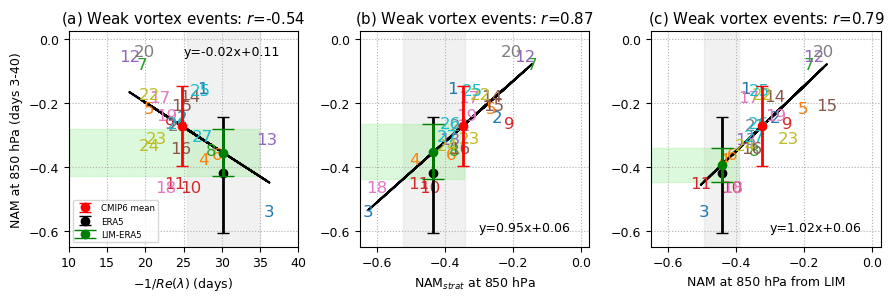

In [24]:
lag_time = 42    # days = [3:40]
colors = plt.cm.tab10(np.linspace(0, 1, len(D_list)))

confidence_level = 0.95
alpha = 1 - confidence_level
ci_y2_k = np.percentile(dis3.y2_k_event[lag_time+1:].mean(axis=0), [100*(alpha/2), 100*(1-alpha/2)])
ci_y2_strat_k = np.percentile(dis3.y2_strat_k_event[lag_time+1:].mean(axis=0), [100*(alpha/2), 100*(1-alpha/2)])
ci_y3_k = np.percentile(dis3r.y3_k_event[lag_time+1:].mean(axis=0), [100*(alpha/2), 100*(1-alpha/2)])

x = np.empty((len(D_list)))
y = np.empty_like(x)
fig = plt.figure(figsize=(9, 3.1))
mpl.rcParams.update({'font.size': 9})

fig.add_subplot(1,3,1)
for i, D in enumerate(D_list):
    x[i] = -1/D.model.b[0].real # D.tau10
    y[i] = np.squeeze(y2_k_event[i, lag_time+1:].mean(axis=0))

plt.gca().errorbar(x.mean(), y.mean(), yerr=y.std(), fmt='or', zorder=29, linewidth=2, capsize=4, label='CMIP6 mean')
x0 = -1/D0.model.b[0].real # D0.tau10
y0 = y2_k_event0[lag_time+1:].mean(axis=0)
yerr = [y0-ci_y2_k[0], ci_y2_k[1]-y0]
plt.errorbar(x0, y0, yerr, fmt='ok', linewidth=2, capsize=4, zorder=30, label=D0.data.name)
# plt.plot(x0, y0, 'ok', linewidth=2, label=D0.data.name)
for i, D in enumerate(D_list):
    # plt.plot(x[i], y[i], 'o', mfc='none', linewidth=2, label=D.data.name)
    plt.text(x[i], y[i], str(i+1), ha='center', va='center', color=colors[i], fontsize=12)

res = stats.linregress(x, y)
plt.plot(x, x*res.slope + res.intercept, '-k')
plt.text(25, -0.05, f'y={res.slope:.2f}x+{res.intercept:.2f}')

y0_pred = x0*res.slope + res.intercept
ci_pred_high = -1/ci[0].b_r[0]*res.slope + res.intercept
ci_pred_low = -1/ci[1].b_r[0]*res.slope + res.intercept
yerr = [[y0_pred - ci_pred_low], [ci_pred_high - y0_pred]]
plt.errorbar(x0, y0_pred, yerr, fmt='og', linewidth=2, capsize=8, zorder=31, label='LIM-'+D0.data.name)
plt.legend(fontsize='x-small', loc = 'lower left')

yaxis = np.linspace(-0.65, 0.025, 200)
plt.fill_betweenx(yaxis, -1/ci[0].b_r[0]*np.ones_like(yaxis), -1/ci[1].b_r[0]*np.ones_like(yaxis), zorder=0, color='lightgray', alpha=0.3)

xaxis = np.linspace(10, 40, 200)
y_xaxis = xaxis*res.slope + res.intercept
plt.fill_between(xaxis, ci_pred_low*np.ones_like(xaxis), ci_pred_high*np.ones_like(xaxis), where=ci_pred_low*np.ones_like(xaxis)<y_xaxis, zorder=0, color='lightgreen', alpha=0.3)

plt.gca().invert_xaxis()
plt.title(fr'(a) Weak vortex events: $r$={res.rvalue:.2f}')
plt.xlim((10, 40))
plt.ylim((-0.65, 0.025))
plt.yticks(np.arange(0, -0.61, -0.2))
plt.grid(linestyle=':')
plt.xlabel(r'$-1/Re(\lambda)$ (days)')
plt.ylabel(f'NAM at 850 hPa (days {lag_time-39}-40)')

fig.add_subplot(1,3,2)
for i, D in enumerate(D_list):
    x[i] = np.squeeze(y2_strat_k_event[i, lag_time+1:].mean(axis=0))
    y[i] = np.squeeze(y2_k_event[i, lag_time+1:].mean(axis=0))

plt.gca().errorbar(x.mean(), y.mean(), yerr=y.std(), fmt='or', zorder=29, linewidth=2, capsize=4, label='CMIP6 mean')
x0 = y2_strat_k_event0[lag_time+1:].mean(axis=0)
y0 = y2_k_event0[lag_time+1:].mean(axis=0)
yerr = [y0-ci_y2_k[0], ci_y2_k[1]-y0]
plt.errorbar(x0, y0, yerr, fmt='ok', linewidth=2, capsize=4, zorder=30, label=D0.data.name)
# plt.plot(x0, y0, 'ok', linewidth=2, label=D0.data.name)
# plt.legend()
for i, D in enumerate(D_list):
    # plt.plot(x[i], y[i], 'o', linewidth=2, mfc='none', label=D.data.name)
    plt.text(x[i], y[i], str(i+1), ha='center', va='center', color=colors[i], fontsize=12)

res = stats.linregress(x, y)
plt.plot(x, x*res.slope + res.intercept, '-k')
plt.text(-0.3, -0.6, f'y={res.slope:.2f}x+{res.intercept:.2f}')

y0_pred = x0*res.slope + res.intercept
ci_pred_low = ci_y2_strat_k[0]*res.slope + res.intercept
ci_pred_high = ci_y2_strat_k[1]*res.slope + res.intercept
yerr = [y0_pred - ci_pred_low, ci_pred_high - y0_pred]
plt.errorbar(x0, y0_pred, yerr, fmt='og', linewidth=2, capsize=8, zorder=31, label=D0.data.name)

yaxis = np.linspace(-0.65, 0.025, 200)
plt.fill_betweenx(yaxis, ci_y2_strat_k[0]*np.ones_like(yaxis), ci_y2_strat_k[1]*np.ones_like(yaxis), zorder=0, color='lightgray', alpha=0.3)

xaxis = np.linspace(-0.65, 0.025, 200)
y_xaxis = xaxis*res.slope + res.intercept
plt.fill_between(xaxis, ci_pred_low*np.ones_like(xaxis), ci_pred_high*np.ones_like(xaxis), where=ci_pred_high*np.ones_like(xaxis)>y_xaxis, zorder=0, color='lightgreen', alpha=0.3)

plt.title(fr'(b) Weak vortex events: $r$={res.rvalue:.2f}')
plt.xlim((-0.65, 0.025))
plt.ylim((-0.65, 0.025))
plt.yticks(np.arange(0, -0.61, -0.2))
plt.grid(linestyle=':')
plt.xlabel(r"NAM$_{strat}$ at 850 hPa")
# plt.ylabel('850 hPa anomalies')
# plt.legend()

fig.add_subplot(1,3,3)
for i, D in enumerate(D_list):
    x[i] = np.squeeze(y3_k_event[i, lag_time+1:].mean(axis=0))
    y[i] = np.squeeze(y2_k_event[i, lag_time+1:].mean(axis=0))

plt.gca().errorbar(x.mean(), y.mean(), yerr=y.std(), fmt='or', zorder=29, linewidth=2, capsize=4, label='CMIP6 mean')
x0 = y3_k_event0[lag_time+1:].mean(axis=0)
y0 = y2_k_event0[lag_time+1:].mean(axis=0)
yerr = [y0-ci_y2_k[0], ci_y2_k[1]-y0]
plt.errorbar(x0, y0, yerr, fmt='ok', linewidth=2, capsize=4, zorder=30, label=D0.data.name)
# plt.plot(x0, y0, 'ok', linewidth=2, label=D0.data.name)
for i, D in enumerate(D_list):
    # plt.plot(x[i], y[i], 'o', linewidth=2, mfc='none', markersize=12, color=colors[i], label=D.data.name)
    plt.text(x[i], y[i], str(i+1), ha='center', va='center', color=colors[i], fontsize=12)

res = stats.linregress(x, y)
plt.plot(x, x*res.slope + res.intercept, '-k')
plt.text(-0.3, -0.6, f'y={res.slope:.2f}x+{res.intercept:.2f}')

y0_pred = x0*res.slope + res.intercept
ci_pred_low = ci_y3_k[0]*res.slope + res.intercept
ci_pred_high = ci_y3_k[1]*res.slope + res.intercept
yerr = [y0_pred - ci_pred_low, ci_pred_high - y0_pred]
plt.errorbar(x0, y0_pred, yerr, fmt='og', linewidth=2, capsize=8, zorder=31, label=D0.data.name)

yaxis = np.linspace(-0.65, 0.025, 200)
plt.fill_betweenx(yaxis, ci_y3_k[0]*np.ones_like(yaxis), ci_y3_k[1]*np.ones_like(yaxis), zorder=0, color='lightgray', alpha=0.3)

xaxis = np.linspace(-0.65, 0.025, 200)
y_xaxis = xaxis*res.slope + res.intercept
plt.fill_between(xaxis, ci_pred_low*np.ones_like(xaxis), ci_pred_high*np.ones_like(xaxis), where=ci_pred_high*np.ones_like(xaxis)>y_xaxis, zorder=0, color='lightgreen', alpha=0.3)

plt.title(fr'(c) Weak vortex events: $r$={res.rvalue:.2f}')
plt.xlim((-0.65, 0.025))
plt.ylim((-0.65, 0.025))
plt.yticks(np.arange(0, -0.61, -0.2))
plt.grid(linestyle=':')
plt.xlabel('NAM at 850 hPa from LIM')
# plt.ylabel('850 hPa anomalies')
# plt.legend()

plt.tight_layout()
# plt.savefig('Figs/AM_event_cmip6_LIM4.pdf', bbox_inches="tight",transparent=True)

Checking CI: [25.44394617 34.9857768 ] and (np.float64(25.443945466542658), np.float64(34.98577659731728))
Checking CI: [0.02207894 0.03336851] and (np.float64(0.022078942973166704), np.float64(0.03336850740015507))
Checking CI: [-0.60593309 -0.24387817] and [-0.60593309 -0.24387817]
Checking CI: [-0.49375859 -0.3906775 ] and [-0.49375859 -0.3906775 ]


[Text(1, 0, 'ACCESS-CM2'),
 Text(2, 0, 'BCC-ESM1'),
 Text(3, 0, 'CanESM5'),
 Text(4, 0, 'CESM2'),
 Text(5, 0, 'CESM2-WACCM'),
 Text(6, 0, 'CNRM-CM6'),
 Text(7, 0, 'CNRM-CM6-HR'),
 Text(8, 0, 'CNRM-ESM2'),
 Text(9, 0, 'EC-Earth3'),
 Text(10, 0, 'FGOALS-f3-L'),
 Text(11, 0, 'FGOALS-g3'),
 Text(12, 0, 'GFDL-ESM4'),
 Text(13, 0, 'HadGEM3-GC31-LL'),
 Text(14, 0, 'HadGEM3-GC31-MM'),
 Text(15, 0, 'INM-CM4'),
 Text(16, 0, 'INM-CM5'),
 Text(17, 0, 'IPSL-CM6A-LR'),
 Text(18, 0, 'KACE'),
 Text(19, 0, 'MIROC6'),
 Text(20, 0, 'MIROC-ES2L'),
 Text(21, 0, 'MPI-ESM-1-2-HAM'),
 Text(22, 0, 'MPI-ESM1-2-HR'),
 Text(23, 0, 'MPI-ESM1-2-LR'),
 Text(24, 0, 'MRI-ESM2'),
 Text(25, 0, 'NorESM2-LM'),
 Text(26, 0, 'NorESM2-MM'),
 Text(27, 0, 'UKESM1')]

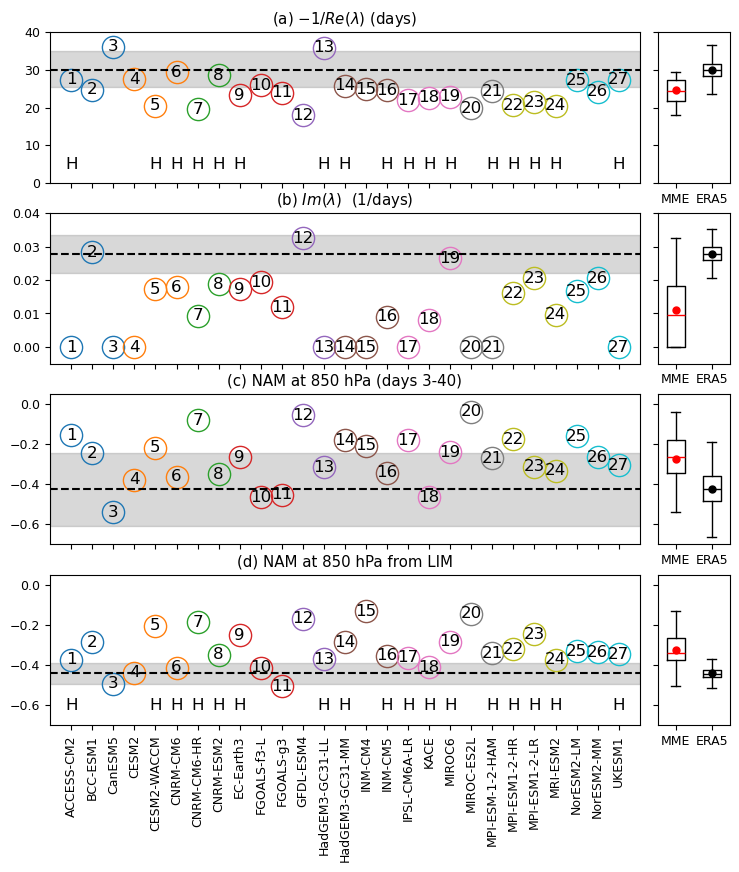

In [25]:
colors = plt.cm.tab10(np.linspace(0, 1, len(D_list)))

def plot_boxplots(var_list, var0_list, ci, ax11, yticks, ylims, title, hightop=None):
    nD = len(var_list)
    print(f'Checking CI: {np.percentile(var0_list, [100*(alpha/2), 100*(1-alpha/2)])} and {ci}')
    for i, var in enumerate(var_list):
        ax11.plot(i+1, var, marker='o', color=colors[i], mfc='none', markersize=16)
        plt.text(i+1, var, str(i+1), ha='center', va='center', color='k', fontsize=12)
        if hightop and model_top[i]<1.0:
             plt.text(i+1, hightop, "H", ha='center', va='center', color='k', fontsize=12)
    plt.fill_between(range(nD+2), ci[0], ci[1], color='gray', alpha=0.3)
    ax11.plot(range(nD+2), var0_list.mean()*np.ones((nD+2,1)),'--k')
    ax11.set_title(title)
    ax11.set_xlim(0, nD+1)
    ax11.set_xticks(np.arange(1,nD+1))
    ax11.set_xticklabels([], rotation='vertical')
    ax11.set_ylim(*ylims)
    ax11.set_yticks(yticks)

    fig1.subplots_adjust(right=0.78)
    box_ax11 = fig1.add_axes([0.80, ax11.get_position().y0, 0.08, ax11.get_position().y1-ax11.get_position().y0])
    box_ax11.boxplot(var_list, positions=np.array([1]), widths=0.5, showmeans=True, showfliers=False, \
                    meanprops=dict(marker='o',markerfacecolor='red',markeredgecolor='red', markersize=5),
                    medianprops=dict(color="red"))
    box_ax11.boxplot(var0_list, positions=np.array([2]), widths=0.5, showmeans=True, showfliers=False, \
                    meanprops=dict(marker='o',markerfacecolor='black',markeredgecolor='black', markersize=5),
                    medianprops=dict(color="black"))
    box_ax11.set_xticks([1, 2])
    box_ax11.set_xticklabels(['MME','ERA5'])
    box_ax11.set_ylim(*ylims)
    box_ax11.set_yticks(yticks)
    box_ax11.set_yticklabels([])

    ax11.set_xticks(np.arange(1,nD+1))
    ax11.set_xlim(0,nD+1)

fig1 = plt.figure(figsize=(9,9))
nD = len(D_list)

ax11 = fig1.add_subplot(4, 1, 1)
var_list = np.zeros((nD, ))
for i, D in enumerate(D_list):
    var_list[i] = -1/D.model.b[0].real
var0_list = -1/dis.b_r[0]
yticks, ylims = np.arange(0, 41, 10), (0, 40)
title = '(a) '+ r'$-1/Re(\lambda)$ (days)'
plot_boxplots(var_list, var0_list, (-1/ci[0].b_r[0], -1/ci[1].b_r[0]), ax11, yticks, ylims, title, hightop=5)

ax11 = fig1.add_subplot(4, 1, 2)
var_list = np.zeros((nD, ))
for i, D in enumerate(D_list):
    var_list[i] = D.model.b[0].imag
var0_list = dis.b_i[0]
yticks, ylims = np.arange(0, 0.041, 0.01), (-0.005, 0.04)
title = '(b) '+ r'$Im(\lambda)$  (1/days)'
plot_boxplots(var_list, var0_list, (ci[0].b_i[0], ci[1].b_i[0]), ax11, yticks, ylims, title)

ax11 = fig1.add_subplot(4, 1, 3)
var_list = np.zeros((nD, ))
for i, D in enumerate(D_list):
    var_list[i] = np.squeeze(y2_k_event[i, lag_time+1:].mean(axis=0))
var0_list = dis3.y2_k_event[lag_time+1:,:].mean(axis=0)
yticks, ylims = np.arange(0, -0.7, -0.2), (-0.7, 0.05)
title = f'(c) NAM at 850 hPa (days {lag_time-39}-40)'
plot_boxplots(var_list, var0_list, ci_y2_k, ax11, yticks, ylims, title)
    
ax11 = fig1.add_subplot(4, 1, 4)
var_list = np.zeros((nD, ))
for i, D in enumerate(D_list):
    var_list[i] = np.squeeze(y3_k_event[i, lag_time+1:].mean(axis=0))
var0_list = dis3r.y3_k_event[lag_time+1:,:].mean(axis=0)
yticks, ylims = np.arange(0, -0.7, -0.2), (-0.7, 0.05)
title = f'(d) NAM at 850 hPa from LIM'
plot_boxplots(var_list, var0_list, ci_y3_k, ax11, yticks, ylims, title, hightop=-0.6)
ax11.set_xticklabels(model_list, rotation='vertical')

# plt.savefig('Figs/LIM_timescales.pdf', bbox_inches="tight", transparent=True)
